BlazePose is a novel convolutional neural network architecture for human pose estimation that can run in real-time on mobile devices. It can detect 33 body keypoints, including face, hands, and feet, which are useful for applications like fitness, dance, and gesture control. BlazePose is based on a two-step detector-tracker pipeline that first locates the pose region-of-interest and then predicts the keypoints from it. BlazePose outperforms existing pose models in terms of accuracy, speed, and memory. BlazePose can also provide clinically viable body keypoints for virtual motion assessment.


[
https://arxiv.org/abs/2006.10204
](https://)



#Installations and dependensies

In [26]:
#@title Mediapipe instalation
!pip install mediapipe

Defaulting to user installation because normal site-packages is not writeable


## Download tools from github:

In [27]:
user = "ItayCoifman"
repo = "blazepose-mediapipe-example"
src_dir = "tools"
pyfile = "video.py"
url = f"https://raw.githubusercontent.com/{user}/{repo}/main/{src_dir}/{pyfile}"
!wget --no-cache --backups=1 {url};
pyfile = "visualize.py"
url = f"https://raw.githubusercontent.com/{user}/{repo}/main/{src_dir}/{pyfile}"
!wget --no-cache --backups=1 {url};
pyfile = "utils.py"
url = f"https://raw.githubusercontent.com/{user}/{repo}/main/{src_dir}/{pyfile}"
!wget --no-cache --backups=1 {url};

--2025-12-07 19:07:38--  https://raw.githubusercontent.com/ItayCoifman/blazepose-mediapipe-example/main/tools/video.py
Résolution de raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connexion à raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 7213 (7,0K) [text/plain]
Enregistre : ‘video.py’

video.py            100%[===================>]   7,04K  --.-KB/s    ds 0s      

2025-12-07 19:07:38 (37,9 MB/s) - ‘video.py’ enregistré [7213/7213]

--2025-12-07 19:07:38--  https://raw.githubusercontent.com/ItayCoifman/blazepose-mediapipe-example/main/tools/visualize.py
Résolution de raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connexion à raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443… connecté.
requête HTTP transmise, en attente de la réponse

## Imports

In [28]:
# from tools import video,utils,visualize
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable


In [29]:
from video import Video
import visualize
from utils import landmarks_2_table
import mediapipe as mp
import os
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from IPython.display import clear_output, display
import nbimporter
from extract_videos_by_label import get_DESRes_videos_by_label, get_jester_videos_by_label
import joblib


## Functions

In [30]:
def video_pose_estimation_2D(video_path: str,
                          output_path: str = None,
                          save_video: bool = False,
                          verbose: bool = True):
    """
    Applique BlazePose à une vidéo.

    Args:
        video_path: chemin de la vidéo d'entrée.
        output_path: chemin de la vidéo de sortie (si save_video=True).
        save_video: si True, écrit une vidéo annotée.
        verbose: affichage des infos.

    Returns:
        vid_out (Video ou None),
        marker_df,
        visibility_df
    """
    output = []
    timestamps = []

    vid = Video.from_path(video_path)
    video_name = os.path.basename(video_path)

    # Reader
    vid_cap = cv2.VideoCapture(vid.path)

    # Writer optionnel
    video_writer = None
    if save_video:
        if output_path is None:
            base, ext = os.path.splitext(video_path)
            output_path = base + "_pose.mp4"
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        video_writer = cv2.VideoWriter(output_path, fourcc, vid.fps, (vid.width, vid.height))

    if verbose:
        print(f"Processing- Name- {video_name}:")
        print(f" Width- {vid.width}, Height- {vid.height} ")
        print(f" number of frames- {vid.nFrames}, Fps- {vid.fps} ")
        print(f" Path-{video_path} \n")

    # BlazePose
    with mp.solutions.pose.Pose(
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
    ) as pose:

        for frame_index in tqdm(range(vid.nFrames)):
            success, img = vid_cap.read()
            if not success:
                break

            # BGR -> RGB
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # timestamp
            timestamps.append(vid_cap.get(cv2.CAP_PROP_POS_MSEC))

            # Inference
            results = pose.process(img_rgb)
            output.append(results)

            # Dessin + écriture vidéo seulement si demandé
            if save_video and video_writer is not None:
                img_out = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
                mp.solutions.drawing_utils.draw_landmarks(
                    img_out,
                    results.pose_landmarks,
                    mp.solutions.pose.POSE_CONNECTIONS,
                    landmark_drawing_spec=mp.solutions.drawing_styles.get_default_pose_landmarks_style()
                )
                video_writer.write(img_out)

    # Fermer ressources
    if video_writer is not None:
        video_writer.release()
    cv2.destroyAllWindows()

    # Landmarks -> tables
    try:
        marker_df, visibility_df = landmarks_2_table(
            output,
            time_vec=np.array(timestamps) / 1000.0
        )
    except Exception as e:
        print("⚠️ landmarks_2_table a échoué:", repr(e))
        marker_df, visibility_df = output, []
        print("please replace the video")

    vid_out = Video.from_path(output_path) if (save_video and output_path is not None) else None
    return vid_out, marker_df, visibility_df


# BlazePose Mediapipe - Extract Pose Estimation From Video:

## Upload your video

Labels disponibles : ['one', 'finger', 'cup', 'knock', 'clasp', 'hold', 'punch', 'point', 'wave', 'show', 'soft', 'present', 'hand']

In [31]:
#use case
videos = get_DESRes_videos_by_label("point", 10)
videos


['GESRes_filtered_gestures/point/1664_Lecturer1_point_forward.mp4',
 'GESRes_filtered_gestures/point/1679_Lecturer1_point_forward.mp4',
 'GESRes_filtered_gestures/point/864_Politician3_point_up.mp4',
 'GESRes_filtered_gestures/point/859_Politician3_point_moving.mp4',
 'GESRes_filtered_gestures/point/1173_Clinician1_point_forward.mp4',
 'GESRes_filtered_gestures/point/2276_Lecturer3_point_down.mp4',
 'GESRes_filtered_gestures/point/2174_Lecturer3_point_to_side.mp4',
 'GESRes_filtered_gestures/point/1666_Lecturer1_point_forward.mp4',
 'GESRes_filtered_gestures/point/838_Politician3_point_up.mp4',
 'GESRes_filtered_gestures/point/881_Politician3_point_forward.mp4']

Labels disponibles : ['Drumming Fingers','Pushing Two Fingers Away','Sliding Two Fingers Down','Stop Sign','Swiping Up','Turning Hand Counterclockwise','Zooming Out With Two Fingers',
				'Pulling Hand In' ,'Rolling Hand Backward','Sliding Two Fingers Left'  , 'Swiping Down',  'Thumb Down' ,'Zooming In With Full Hand',
				'Pulling Two Fingers In','Rolling Hand Forward','Sliding Two Fingers Right','Swiping Left',  'Thumb Up' , 'Zooming In With Two Fingers',
				'Pushing Hand Away','Shaking Hand','Sliding Two Fingers Up', 'Swiping Right','Turning Hand Clockwise' ,'Zooming Out With Full Hand']


In [32]:
videos = get_jester_videos_by_label("Stop Sign", 5)
videos

['Jester_filtered_gestures/Stop Sign/58987.mp4',
 'Jester_filtered_gestures/Stop Sign/63151.mp4',
 'Jester_filtered_gestures/Stop Sign/31171.mp4',
 'Jester_filtered_gestures/Stop Sign/144349.mp4',
 'Jester_filtered_gestures/Stop Sign/28568.mp4']

## Veiw your results
Notice- Convert function is only used for presenting Video in google Colab

# Normalization

In [33]:
from scipy.signal import savgol_filter

def smooth_sequence(data, window=9, poly=3):
    """
    data : (T, D)
    Lisse chaque colonne indépendamment.
    """
    return savgol_filter(data, window_length=window, polyorder=poly, axis=0)


In [34]:
KEYPOINTS = [0, 2, 5] + list(range(7, 25)) # keypoints à utiliser
VIS_THRESH = 0.5  # seuil de visibilité (à ajuster si besoin)


def marker_to_traj_vec(marker_df,
                       visibility_df,
                       keypoints=KEYPOINTS,
                       target_len: int = 50,
                       vis_thresh: float = VIS_THRESH) -> np.ndarray:
    """
    Transforme marker_df (T_raw, 100) + visibility_df en une trajectoire
    normalisée et vectorisée pour DMP.

    Accepte indifféremment:
      - marker_df : np.ndarray ou pandas.DataFrame
      - visibility_df : np.ndarray ou pandas.DataFrame

    Retourne:
        traj_vec : (T, 2 * len(keypoints))  -> typiquement (50, 32)
        (coords = (y,z) normalisés par les épaules, resamplés en target_len)
    """

    # ---- 0) Conversion éventuelle DataFrame -> ndarray ----
    if isinstance(marker_df, pd.DataFrame):
        marker_df = marker_df.to_numpy()
    if isinstance(visibility_df, pd.DataFrame):
        visibility_df = visibility_df.to_numpy()

    T_raw = marker_df.shape[0]
    n_kp = len(keypoints)

    # -------- 1) Récupérer le temps --------
    t_src = marker_df[:, 0]  # (T_raw,)

    # -------- 2) Extraire (y, z) pour les keypoints choisis --------
    # marker_df: [time, x0,y0,z0, x1,y1,z1, ...]
    seq_yz = np.zeros((T_raw, n_kp, 2), dtype=float)  # (T_raw, 16, 2)

    for i, kp in enumerate(keypoints):
        base = 1 + 3 * kp  # x = base, y = base+1, z = base+2
        y_col = base + 1
        z_col = base + 2
        seq_yz[:, i, 0] = marker_df[:, y_col]
        seq_yz[:, i, 1] = marker_df[:, z_col]

    # -------- 3) Appliquer le masque de visibilité --------
    # visibility_df: [time, vis_0, vis_1, ..., vis_32]
    vis_sel = np.zeros((T_raw, n_kp), dtype=float)
    for i, kp in enumerate(keypoints):
        vis_col = 1 + kp
        vis_sel[:, i] = visibility_df[:, vis_col]

    # Mettre les points peu visibles à NaN
    mask_invis = (vis_sel < vis_thresh) | ~np.isfinite(vis_sel)
    seq_yz[mask_invis, :] = np.nan

    # -------- 4) Remplir les NaN par interpolation temporelle --------
    # On interpole chaque dimension (joint, coord) indépendamment
    seq_flat = seq_yz.reshape(T_raw, -1)  # (T_raw, n_kp*2)
    
    # Apply a Savitzky-Golay filter to an array.
    seq_flat = smooth_sequence(seq_flat, window=9, poly=3)

    for d in range(seq_flat.shape[1]):
        vals = seq_flat[:, d]
        finite = np.isfinite(vals)
        if finite.sum() >= 2:
            # interpolation sur les indices de temps (ou t_src si tu préfères)
            seq_flat[:, d] = np.interp(
                np.arange(T_raw),
                np.arange(T_raw)[finite],
                vals[finite]
            )
        else:
            # si quasi rien de valide : on met à 0
            seq_flat[:, d] = 0.0

    seq_yz_filled = seq_flat.reshape(T_raw, n_kp, 2)  # (T_raw, 16, 2)

    # -------- 5) Normalisation par les épaules (centrage + scale) --------
    # On suppose que 11 et 12 sont dans keypoints
    try:
        idx_sh_l = keypoints.index(11)
        idx_sh_r = keypoints.index(12)
    except ValueError:
        raise ValueError("Les keypoints 11 et 12 (épaules) doivent être dans KEYPOINTS.")

    shoulder_L = seq_yz_filled[:, idx_sh_l, :]  # (T_raw, 2)
    shoulder_R = seq_yz_filled[:, idx_sh_r, :]  # (T_raw, 2)

    centers = 0.5 * (shoulder_L + shoulder_R)  # (T_raw, 2)
    seq_centered = seq_yz_filled - centers[:, None, :]  # (T_raw, 16, 2)

    # Distance épaule-épaule pour chaque frame
    shoulder_dist = np.linalg.norm(shoulder_R - shoulder_L, axis=1)  # (T_raw,)
    finite_sd = shoulder_dist[np.isfinite(shoulder_dist) & (shoulder_dist > 1e-6)]
    if finite_sd.size == 0:
        scale = 1.0
    else:
        scale = np.mean(finite_sd)

    seq_norm = seq_centered / scale  # (T_raw, 16, 2)

    # -------- 6) Normalisation temporelle à target_len frames --------
    if target_len is not None and target_len > 0:
        # On interpole dans le temps réel t_src
        t_new = np.linspace(t_src[0], t_src[-1], target_len)
        seq_norm_flat = seq_norm.reshape(T_raw, -1)  # (T_raw, 32)
        seq_resampled_flat = np.zeros((target_len, seq_norm_flat.shape[1]), dtype=float)

        for d in range(seq_norm_flat.shape[1]):
            seq_resampled_flat[:, d] = np.interp(
                t_new, t_src, seq_norm_flat[:, d]
            )

        seq_resampled = seq_resampled_flat.reshape(target_len, n_kp, 2)  # (target_len, 16, 2)
        T_out = target_len
    else:
        seq_resampled = seq_norm
        T_out = T_raw

    # -------- 7) Vectorisation finale pour DMP : (T_out, 2 * n_kp) --------
    traj_vec = seq_resampled.reshape(T_out, n_kp * 2)  # (T_out, 32)

    return traj_vec


# DMP


In [35]:
class DMPVector:
    def __init__(self, n_basis: int = 20):
        self.n_basis = n_basis #number of gaussians
        self.centers = None
        self.widths = None
        self.W = None       # (n_basis, D)
        self.y0 = None      # (D,)
        self.g = None       # (D,)
        self.T_train = None

    #define each psi function
    def _basis_functions(self, T: int):
        t = np.linspace(0.0, 1.0, T)
        self.centers = np.linspace(0.0, 1.0, self.n_basis)
        self.widths = np.ones(self.n_basis) * (self.n_basis ** 2)
        psi = np.exp(-self.widths * (t[:, None] - self.centers[None, :])**2)
        return psi, t

    def fit(self, Y: np.ndarray):
        T, D = Y.shape
        self.T_train = T
        self.y0 = Y[0].copy()
        self.g  = Y[-1].copy()     #goal point for each trajectory

        psi, t = self._basis_functions(T)   # psi: (T, n_basis)

        # Composante linéaire entre y0 et g pour chaque dimension
        Y_lin = self.y0 + np.outer(t, (self.g - self.y0))   # (T, D)

        # Composante non linéaire à approximer
        F_target = Y - Y_lin                                # (T, D)

        # Normalisation des bases
        psi_sum  = np.sum(psi, axis=1, keepdims=True) + 1e-10
        psi_norm = psi / psi_sum                           # (T, n_basis)

        # Résolution des poids W dans F_target ≈ psi_norm @ W
        # psi_norm: (T, n_basis), F_target: (T, D) -> W: (n_basis, D)
        self.W, _, _, _ = np.linalg.lstsq(psi_norm, F_target, rcond=None)

    def fit_multi(self, Y_batch: np.ndarray):
        """
        Y_batch : (N, T, D) — ensemble de N démos pour un même geste
        Apprend un seul W en empilant toutes les F_target.
        """
        N, T, D = Y_batch.shape
        self.T_train = T

        # base functions communes
        psi, t = self._basis_functions(T)           # (T, n_basis)
        psi_sum  = np.sum(psi, axis=1, keepdims=True) + 1e-10
        psi_norm = psi / psi_sum                    # (T, n_basis)

        # On va empiler toutes les F_target
        F_list = []

        # Pour la partie linéaire de référence, on choisit les moyennes des y0, g
        y0_all = []
        g_all  = []

        for i in range(N):
            Y = Y_batch[i]              # (T, D)
            y0_i = Y[0].copy()
            g_i  = Y[-1].copy()

            y0_all.append(y0_i)
            g_all.append(g_i)

            Y_lin_i = y0_i + np.outer(t, (g_i - y0_i))   # (T, D)
            F_i     = Y - Y_lin_i                        # (T, D)
            F_list.append(F_i)

        # Empilement
        F_all = np.concatenate(F_list, axis=0)           # (N*T, D)
        Psi_big = np.tile(psi_norm, (N, 1))              # (N*T, n_basis)

        # Régression globale
        self.W, _, _, _ = np.linalg.lstsq(Psi_big, F_all, rcond=None)

        # y0, g moyens pour ce geste
        self.y0 = np.mean(np.stack(y0_all, axis=0), axis=0)  # (D,)
        self.g  = np.mean(np.stack(g_all, axis=0),  axis=0)  # (D,)


    def rollout(self, T: int = None, amplitude_scale: float = 1.0) -> np.ndarray:
        """
        Génère une nouvelle trajectoire :
        - T : nombre de pas (si None -> même T que l'entraînement)
        - amplitude_scale : scaling global de la partie non-linéaire
        Retour : (T, D)
        """
        if T is None:
            T = self.T_train

        psi, t = self._basis_functions(T)
        psi_sum  = np.sum(psi, axis=1, keepdims=True) + 1e-10
        psi_norm = psi / psi_sum

        # F: (T, D)
        F = psi_norm @ self.W * amplitude_scale

        # partie linéaire entre y0 et g
        Y_lin = self.y0 + np.outer(t, (self.g - self.y0))

        Y = Y_lin + F
        return Y


# Dataset usage



In [36]:
#Given a label and a number of video, extract marker_df and visibility_df 
#Then, normalize and resample them to build a dataset for DMP training
#output : X (N, T, 32) and video_paths (list of N strings): array of shape (N, T, 32) where N is number of videos

labels_DESRes = ['one', 'finger', 'cup', 'knock', 'clasp', 'hold', 'punch', 'point', 'wave', 'show', 'soft', 'present', 'hand']
labels_jester_full = ['Drumming Fingers','Pushing Two Fingers Away','Sliding Two Fingers Down','Stop Sign','Swiping Up','Turning Hand Counterclockwise','Zooming Out With Two Fingers',
				'Pulling Hand In' ,'Rolling Hand Backward','Sliding Two Fingers Left'  , 'Swiping Down',  'Thumb Down' ,'Zooming In With Full Hand',
				'Pulling Two Fingers In','Rolling Hand Forward','Sliding Two Fingers Right','Swiping Left',  'Thumb Up' , 'Zooming In With Two Fingers',
				'Pushing Hand Away','Shaking Hand','Sliding Two Fingers Up', 'Swiping Right','Turning Hand Clockwise' ,'Zooming Out With Full Hand']

labels_jester = ['Stop Sign', 'Drumming Fingers', 'Thumb Up', 'Thumb Down', 'Turning Hand Counterclockwise', 'Turning Hand Clockwise', 
                 'Rolling Hand Backward', 'Rolling Hand Forward', 'Pushing Hand Away', 'Shaking Hand']



# Results analysis 

In [37]:
#Function evaluation DMP reconstruction

def evaluate_dmp_reconstruction(dmp, X_batch):
    """
    X_batch : (N, T, D)
    Retourne :
    - rmse_all : (N,) RMSE globale par démo
    - rmse_per_frame : (N, T) RMSE par frame
    """
    N, T, D = X_batch.shape

    # Reconstructions
    Y_hat = np.zeros_like(X_batch)

    for i in range(N):
        Y_hat[i] = dmp.rollout(T=T)  # Reconstruction DMP

    err = X_batch - Y_hat  # (N, T, D)

    rmse_per_frame = np.sqrt(np.mean(err**2, axis=2))  # (N, T)
    rmse_all = np.sqrt(np.mean(err**2, axis=(1,2)))    # (N,)
    rmse_mean = rmse_all.mean()

    return rmse_all, rmse_per_frame, rmse_mean

Utiliser fonction analyse_label("label") pour visualiser les résultats obtenus pour un label.

In [ ]:
def analyse_label_filtered(label, 
                           n=100, 
                           target_len=50, 
                           n_basis=30, 
                           rmse_threshold=0.35,
                           joblib_dir="datasets_2D"):

    # ---------------------------------------------------------
    # 1) Charger toutes les vidéos correspondant au label
    # ---------------------------------------------------------
    if label in labels_DESRes:
        video_paths = get_DESRes_videos_by_label(label, n)
    elif label in labels_jester:
        video_paths = get_jester_videos_by_label(label, n)
    else:
        raise ValueError(f"❌ Label '{label}' non reconnu.")

    X_raw = []
    vids_raw = []

    # ---------------------------------------------------------
    # 2) Extraction des trajectoires
    # ---------------------------------------------------------
    print(f"\n🔎 Extraction vidéos du label '{label}' ...")

    for vp in video_paths:
        try:
            marker_df, visibility_df = video_pose_estimation_2D(
                vp, save_video=False, verbose=False)

            traj = marker_to_traj_vec(marker_df, visibility_df, target_len=target_len)

            X_raw.append(traj)
            vids_raw.append(vp)

        except Exception as e:
            print(f"⚠️ Skip {vp} : {repr(e)}")

    if len(X_raw) == 0:
        print(f"❌ Aucune trajectoire valide pour '{label}'")
        return None, None, None, None, [], []

    X_raw = np.stack(X_raw, axis=0)
    N_raw = len(X_raw)

    print(f"➡️ {N_raw} trajectoires extraites")


    # ---------------------------------------------------------
    # 3) Entraînement d’un premier DMP (avant filtrage)
    # ---------------------------------------------------------
    dmp_full = DMPVector(n_basis=n_basis)
    dmp_full.fit_multi(X_raw)

    rmse_all, rmse_per_frame, rmse_mean = evaluate_dmp_reconstruction(dmp_full, X_raw)

    print(f"\n📊 RMSE moyen avant filtrage : {rmse_mean:.4f}")
    print(f"📈 RMSE max : {rmse_all.max():.4f}")


    # ---------------------------------------------------------
    # 4) Filtrage
    # ---------------------------------------------------------
    keep_mask = rmse_all < rmse_threshold

    print(f"🧹 Filtrage : {keep_mask.sum()}/{N_raw} vidéos gardées (< {rmse_threshold})")

    X = X_raw[keep_mask]
    vids = [vids_raw[i] for i in range(N_raw) if keep_mask[i]]

    if len(X) == 0:
        print(f"⚠️ Aucune vidéo n'a passé le filtrage pour le label '{label}'")
        return None, None, None, None, [], rmse_all


    # ---------------------------------------------------------
    # 5) Réentraîner un DMP propre
    # ---------------------------------------------------------
    dmp = DMPVector(n_basis=n_basis)
    dmp.fit_multi(X)

    rmse_all_f, rmse_per_frame_f, rmse_mean_f = evaluate_dmp_reconstruction(dmp, X)

    print(f"\n📊 RMSE moyen après filtrage : {rmse_mean_f:.4f}")
    print(f"📈 RMSE max : {rmse_all_f.max():.4f}")
    print(f"📉 RMSE min : {rmse_all_f.min():.4f}")


    # ---------------------------------------------------------
    # 6) Sauvegarde dans un JOBLIB
    # ---------------------------------------------------------
    os.makedirs(joblib_dir, exist_ok=True)
    joblib_path = os.path.join(joblib_dir, f"{label}.joblib")

    dataset = {
        "label": label,
        "X": X,                           # trajectoires filtrées
        "videos": vids,                   # vidéos gardées
        "dmp": dmp,                       # modèle final
        "rmse_raw": rmse_all,             # erreurs avant filtrage
        "rmse_filtered": rmse_all_f,      # erreurs après filtrage
        "params": {
            "target_len": target_len,
            "n_basis": n_basis,
            "rmse_threshold": rmse_threshold
        }
    }

    joblib.dump(dataset, joblib_path)
    print(f"\n💾 Dataset + DMP sauvegardés dans {joblib_path}")



    # ---------------------------------------------------------
    # 7) Plot final
    # ---------------------------------------------------------
    plt.figure(figsize=(10, 5))
    for i in range(rmse_per_frame_f.shape[0]):
        plt.plot(rmse_per_frame_f[i], alpha=0.25)

    plt.plot(rmse_per_frame_f.mean(axis=0), color='red', linewidth=3, label='Mean')

    plt.title(f"RMSE per frame (filtered) – {label}")
    plt.xlabel("Frame")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()

    return rmse_all_f, rmse_per_frame_f, dmp, X, vids, rmse_all


I0000 00:00:1765102060.755220  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5



🔎 Extraction vidéos du label 'Stop Sign' ...


I0000 00:00:1765102060.756256  438076 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102060.803988  438066 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102060.834938  438064 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.22it/s]
I0000 00:00:1765102061.656074  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102061.657144  438127 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102061.706347  438109 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Stop Sign/85203.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102063.372849  438215 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102063.401514  438222 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 44.28it/s]
I0000 00:00:1765102064.194638  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102064.195950  438280 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102064.248451  438262 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102064.287098  438273 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Stop Sign/108751.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765102070.277633  438638 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102070.323298  438623 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102070.350903  438627 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.85it/s]
I0000 00:00:1765102071.168437  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102071.169616  438689 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102071.212551  438676 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Stop Sign/113189.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765102103.509614  440484 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102103.569021  440470 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102103.606179  440476 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 44.02it/s]
I0000 00:00:1765102104.379166  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102104.380505  440535 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102104.431926  440530 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Stop Sign/49674.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102113.947471  441035 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102113.970790  441039 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.00it/s]
I0000 00:00:1765102114.806164  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102114.807894  441099 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102114.860533  441082 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102114.885642  441093 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Stop Sign/125580.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765102134.810670  442226 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102134.868218  442209 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102134.897355  442221 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.29it/s]
I0000 00:00:1765102135.713786  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102135.715248  442277 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102135.760707  442265 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Stop Sign/18854.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765102147.705637  442945 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102147.758691  442928 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102147.790512  442937 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.46it/s]
I0000 00:00:1765102148.662205  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102148.663137  442996 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102148.707860  442978 inference_feedback_manager.cc:114] Feedba

➡️ 94 trajectoires extraites

📊 RMSE moyen avant filtrage : 0.4621
📈 RMSE max : 1.3310
🧹 Filtrage : 51/94 vidéos gardées (< 0.35)

📊 RMSE moyen après filtrage : 0.1479
📈 RMSE max : 0.3433
📉 RMSE min : 0.0748

💾 Dataset + DMP sauvegardés dans datasets_2D/Stop Sign.joblib


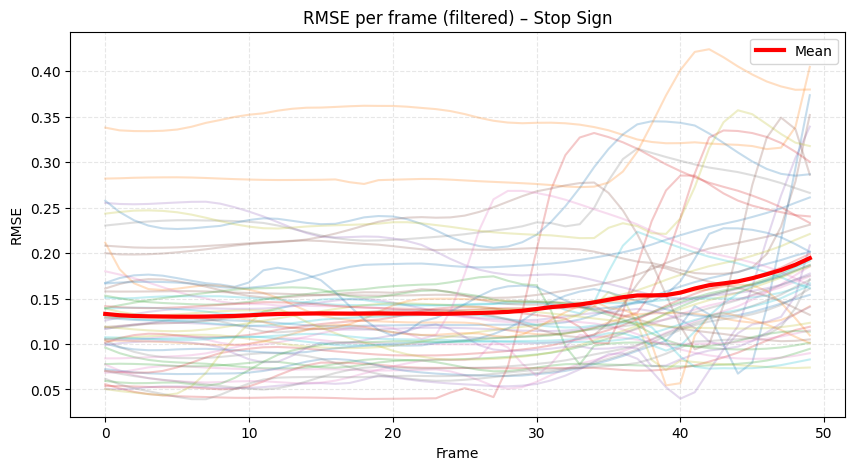

In [39]:
rmse_all, rmse_per_frame, dmp, Xf, vids_f, rmse_raw = analyse_label_filtered(
    "Stop Sign",
    n=100,
    target_len=50,
    n_basis=30,
    rmse_threshold=0.35
)

# Analyse de tous les labels du dataset DESRes en même temps

I0000 00:00:1765102152.595413  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102152.596164  443215 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)


⚠️ Seulement 1 vidéos disponibles pour 'one', mais 100 demandées.
👉 Retour de TOUTES les vidéos disponibles.

🔎 Extraction vidéos du label 'one' ...


  0%|          | 0/313 [00:00<?, ?it/s]W0000 00:00:1765102152.646141  443197 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102152.672357  443198 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 313/313 [00:06<00:00, 46.59it/s]


➡️ 1 trajectoires extraites

📊 RMSE moyen avant filtrage : 0.0190
📈 RMSE max : 0.0190
🧹 Filtrage : 1/1 vidéos gardées (< 0.35)

📊 RMSE moyen après filtrage : 0.0190
📈 RMSE max : 0.0190
📉 RMSE min : 0.0190

💾 Dataset + DMP sauvegardés dans datasets_2D/one.joblib


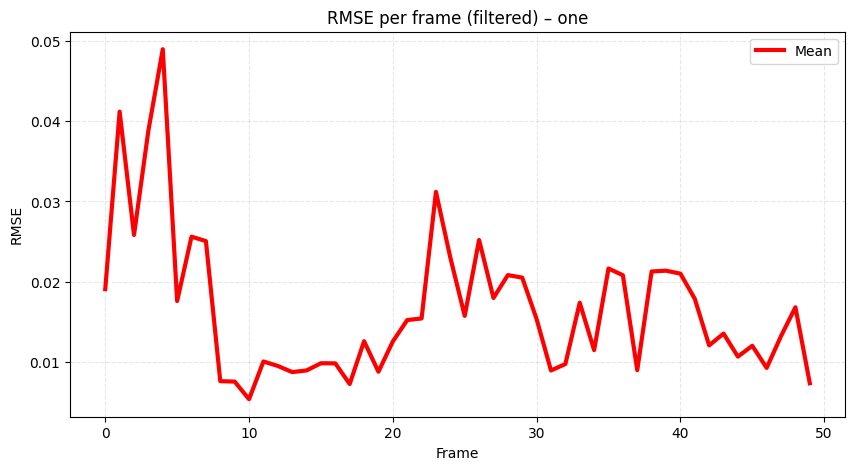

I0000 00:00:1765102159.449511  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102159.450574  443283 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)


(array([0.01899318]), array([[0.0190498 , 0.04121187, 0.02581482, 0.03885547, 0.04900615,
        0.01756641, 0.02560106, 0.02504713, 0.00755989, 0.00750502,
        0.00530347, 0.01001672, 0.00945654, 0.00869186, 0.00889595,
        0.00979633, 0.00978138, 0.00720151, 0.01254565, 0.00873642,
        0.01251348, 0.01518651, 0.01538877, 0.03119503, 0.02297675,
        0.01571242, 0.02518754, 0.01794311, 0.02080376, 0.02048737,
        0.0153107 , 0.00889091, 0.00969841, 0.01735686, 0.01143069,
        0.02162283, 0.02078577, 0.00893271, 0.02125444, 0.0213536 ,
        0.02098504, 0.01784505, 0.01202483, 0.01349973, 0.01062476,
        0.01197931, 0.00921265, 0.01318972, 0.01678481, 0.00730074]]), <__main__.DMPVector object at 0x7d46a71a20e0>, array([[[ 0.44470888,  0.09402404,  0.58527974, ...,  0.48126644,
         -1.57051601, -0.26392888],
        [ 0.42655369,  0.06569737,  0.56552272, ...,  0.52280381,
         -1.57259125, -0.2165078 ],
        [ 0.43519596,  0.12316004,  0.574459

  0%|          | 0/88 [00:00<?, ?it/s]W0000 00:00:1765102159.504821  443265 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102159.534480  443276 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 88/88 [00:02<00:00, 41.78it/s]


➡️ 1 trajectoires extraites

📊 RMSE moyen avant filtrage : 0.0011
📈 RMSE max : 0.0011
🧹 Filtrage : 1/1 vidéos gardées (< 0.35)

📊 RMSE moyen après filtrage : 0.0011
📈 RMSE max : 0.0011
📉 RMSE min : 0.0011

💾 Dataset + DMP sauvegardés dans datasets_2D/finger.joblib


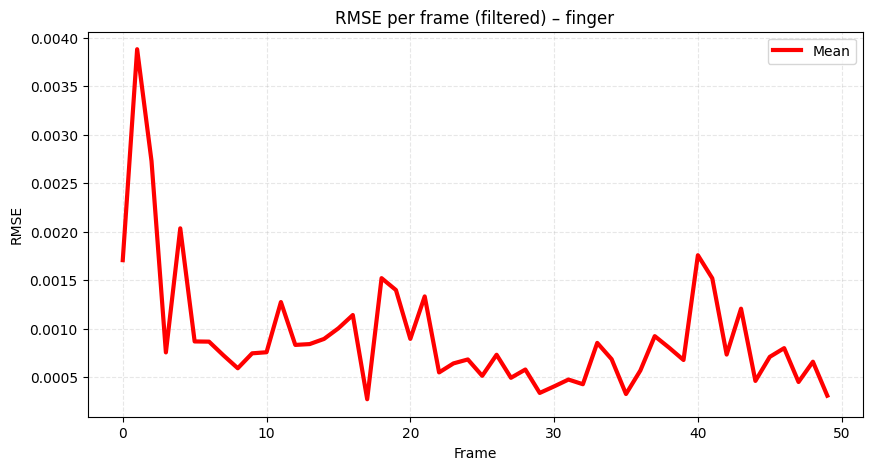

I0000 00:00:1765102161.683296  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.00112337]), array([[0.00170699, 0.0038795 , 0.00272771, 0.00075711, 0.00203485,
        0.00086994, 0.00086792, 0.00072722, 0.00059385, 0.00074759,
        0.00075868, 0.00127576, 0.00083423, 0.00084276, 0.00089598,
        0.00100554, 0.00114206, 0.0002749 , 0.00152176, 0.00139928,
        0.00089643, 0.00133393, 0.00055084, 0.00064378, 0.00068456,
        0.00051587, 0.00073299, 0.00049552, 0.00058073, 0.00033963,
        0.00040692, 0.00047757, 0.00042936, 0.00085502, 0.00068729,
        0.00032855, 0.00057108, 0.00092459, 0.00080552, 0.00067896,
        0.00175806, 0.0015203 , 0.00073466, 0.00120755, 0.00046335,
        0.00071129, 0.000801  , 0.00045243, 0.00066115, 0.00031119]]), <__main__.DMPVector object at 0x7d470454a9b0>, array([[[ 0.46819277,  0.01014223,  0.60296745, ...,  0.25143933,
         -1.3502299 , -0.50220001],
        [ 0.47216865,  0.00742692,  0.61191609, ...,  0.28210714,
         -1.35056865, -0.4700872 ],
        [ 0.46736716,  0.00691349,  0.609257

I0000 00:00:1765102161.684454  443334 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/33 [00:00<?, ?it/s]W0000 00:00:1765102161.735636  443329 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102161.760454  443328 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 33/33 [00:00<00:00, 42.19it/s]
I0000 00:00:1765102162.489306  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102162.490178  443385 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/24 [00:00<?, ?it/s]W0000 00:00:1765102162.539925  443370 inference_feedback_manager.cc:114] Feedba

➡️ 8 trajectoires extraites

📊 RMSE moyen avant filtrage : 0.1187
📈 RMSE max : 0.1875
🧹 Filtrage : 8/8 vidéos gardées (< 0.35)

📊 RMSE moyen après filtrage : 0.1187
📈 RMSE max : 0.1875
📉 RMSE min : 0.0586

💾 Dataset + DMP sauvegardés dans datasets_2D/cup.joblib


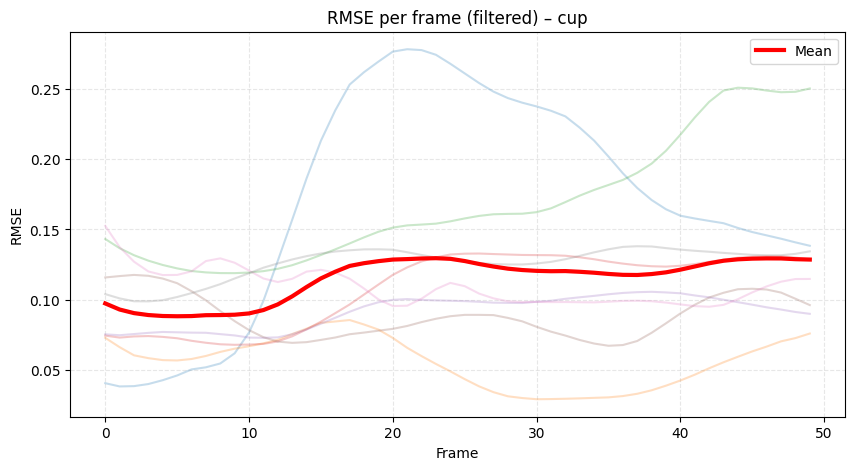

I0000 00:00:1765102168.952651  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.18750251, 0.05861202, 0.17334351, 0.11147361, 0.09224647,
       0.0898392 , 0.11015302, 0.12650211]), array([[0.04056681, 0.03825434, 0.0384719 , 0.0399663 , 0.04270685,
        0.0460614 , 0.05035834, 0.0518741 , 0.05459111, 0.06184306,
        0.0766146 , 0.09918414, 0.12768843, 0.15684821, 0.18631832,
        0.21315686, 0.23483561, 0.25317001, 0.26196794, 0.26947789,
        0.27659435, 0.27829114, 0.27766963, 0.27431801, 0.267935  ,
        0.26107705, 0.25421094, 0.24811728, 0.24351571, 0.24024   ,
        0.23756261, 0.23447782, 0.23049211, 0.22244125, 0.21322787,
        0.20188357, 0.18996228, 0.17951762, 0.17094849, 0.16434855,
        0.15977515, 0.1578067 , 0.15608584, 0.15443515, 0.15105323,
        0.14814664, 0.14578073, 0.14340304, 0.14080513, 0.13838088],
       [0.0728364 , 0.06619553, 0.06040372, 0.05838564, 0.05698841,
        0.05674456, 0.05777704, 0.05994719, 0.06283213, 0.06514042,
        0.06684564, 0.06894819, 0.07140735, 0.07555947, 0.0793793 ,
  

I0000 00:00:1765102168.954142  443743 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/52 [00:00<?, ?it/s]W0000 00:00:1765102169.016797  443726 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102169.054364  443733 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 52/52 [00:01<00:00, 38.99it/s]


➡️ 1 trajectoires extraites

📊 RMSE moyen avant filtrage : 0.0009
📈 RMSE max : 0.0009
🧹 Filtrage : 1/1 vidéos gardées (< 0.35)

📊 RMSE moyen après filtrage : 0.0009
📈 RMSE max : 0.0009
📉 RMSE min : 0.0009

💾 Dataset + DMP sauvegardés dans datasets_2D/knock.joblib


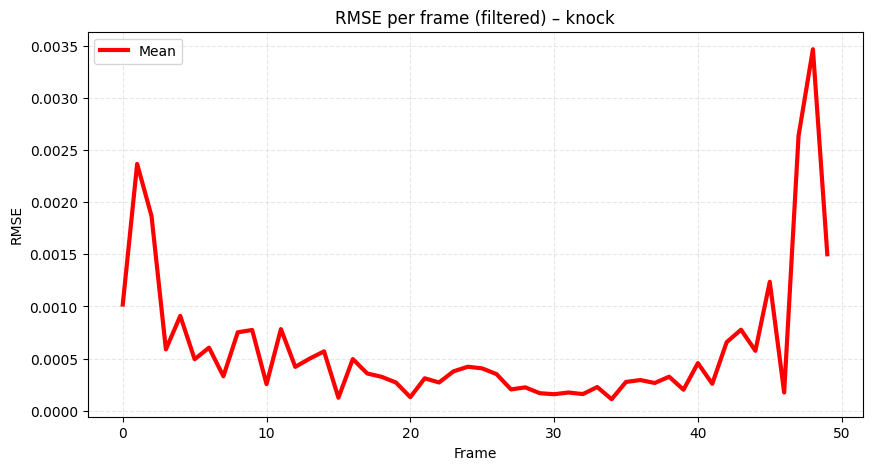

I0000 00:00:1765102170.409275  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102170.410587  443794 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)


(array([0.00090612]), array([[0.00101838, 0.00236631, 0.00186808, 0.00058889, 0.00090993,
        0.00049447, 0.00060541, 0.00033122, 0.00075262, 0.00077473,
        0.00025574, 0.00078351, 0.00042086, 0.00050036, 0.00057007,
        0.00012506, 0.00049598, 0.00035794, 0.00032599, 0.00027123,
        0.0001307 , 0.00031155, 0.00027148, 0.00037806, 0.00042245,
        0.00040638, 0.0003514 , 0.00020499, 0.00022466, 0.00016884,
        0.00015918, 0.00017539, 0.00016034, 0.00022791, 0.00011103,
        0.00027672, 0.00029471, 0.00026661, 0.00032704, 0.00020205,
        0.0004571 , 0.00025879, 0.00065786, 0.00077755, 0.00057526,
        0.00123671, 0.00017558, 0.00263518, 0.00346636, 0.00150053]]), <__main__.DMPVector object at 0x7d4615ff99c0>, array([[[ 0.41267848,  0.06083767,  0.53441724, ...,  0.36222364,
         -1.29408527, -0.26185929],
        [ 0.4255618 ,  0.06984784,  0.54665127, ...,  0.36930851,
         -1.3106976 , -0.25439056],
        [ 0.43249993,  0.08091146,  0.552332

  0%|          | 0/30 [00:00<?, ?it/s]W0000 00:00:1765102170.468994  443776 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102170.494215  443787 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 30/30 [00:00<00:00, 39.50it/s]
I0000 00:00:1765102171.198791  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102171.200477  443845 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/29 [00:00<?, ?it/s]W0000 00:00:1765102171.282459  443830 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102171.307173  443839 inference_feedback_ma

➡️ 5 trajectoires extraites

📊 RMSE moyen avant filtrage : 0.0340
📈 RMSE max : 0.0415
🧹 Filtrage : 5/5 vidéos gardées (< 0.35)

📊 RMSE moyen après filtrage : 0.0340
📈 RMSE max : 0.0415
📉 RMSE min : 0.0288

💾 Dataset + DMP sauvegardés dans datasets_2D/clasp.joblib


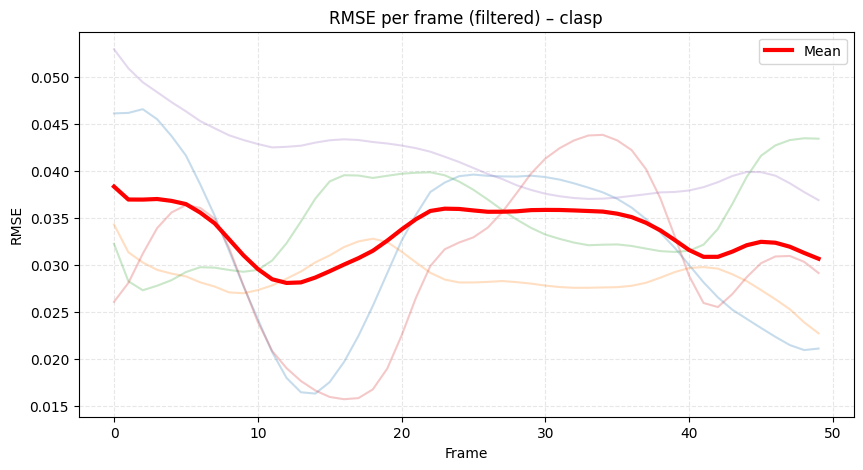

I0000 00:00:1765102175.868866  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.03324824, 0.02880371, 0.03507517, 0.03153389, 0.04152704]), array([[0.04612104, 0.04617201, 0.04656852, 0.04549821, 0.04371132,
        0.04164254, 0.03856197, 0.03524028, 0.03151063, 0.02774064,
        0.02424431, 0.02071821, 0.0179707 , 0.01644156, 0.01630213,
        0.01752689, 0.01967072, 0.02244223, 0.02562982, 0.02910375,
        0.03256385, 0.03532157, 0.03775661, 0.03875864, 0.03943502,
        0.03960725, 0.03947411, 0.03941336, 0.03939578, 0.03949442,
        0.03934273, 0.03907229, 0.03867327, 0.03821353, 0.03771449,
        0.03702655, 0.03609357, 0.03486878, 0.03343397, 0.0318067 ,
        0.02998104, 0.02814641, 0.02654025, 0.02523217, 0.02425705,
        0.02328354, 0.02233984, 0.02146703, 0.02093222, 0.02109474],
       [0.03429201, 0.0313406 , 0.03025062, 0.02946898, 0.0290708 ,
        0.02877439, 0.02813755, 0.02769227, 0.02707025, 0.02698131,
        0.02731598, 0.02781328, 0.02852952, 0.02929393, 0.03026905,
        0.03100432, 0.03189568, 0.03249784, 0

I0000 00:00:1765102175.870283  444053 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/290 [00:00<?, ?it/s]W0000 00:00:1765102175.938627  444035 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102175.975954  444041 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 290/290 [00:06<00:00, 42.31it/s]
I0000 00:00:1765102182.756462  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102182.757164  444108 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/54 [00:00<?, ?it/s]W0000 00:00:1765102182.799477  444095 inference_feedback_manager.cc:114] Fee

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip GESRes_filtered_gestures/hold/2177_Lecturer3_hold.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765102218.232467  445190 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/114 [00:00<?, ?it/s]W0000 00:00:1765102218.276124  445173 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102218.302393  445181 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 114/114 [00:02<00:00, 44.14it/s]
I0000 00:00:1765102220.842562  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/31 [00:00<?, ?it/s]I0000 00:00:1765102220.843512  445241 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765102220.886098  445227 inference_feedback_manager.cc:114] Fee

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip GESRes_filtered_gestures/hold/2099_Lecturer3_hold_close.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765102246.118800  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/65 [00:00<?, ?it/s]I0000 00:00:1765102246.119995  446059 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765102246.199686  446044 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102246.226440  446051 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 65/65 [00:01<00:00, 39.42it/s]
I0000 00:00:1765102247.817049  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102247.820520  446110 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip GESRes_filtered_gestures/hold/2157_Lecturer3_hold_close.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/62 [00:00<?, ?it/s]W0000 00:00:1765102257.089020  446425 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102257.133790  446431 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 62/62 [00:01<00:00, 35.13it/s]
I0000 00:00:1765102258.790593  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102258.791570  446489 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/66 [00:00<?, ?it/s]W0000 00:00:1765102258.840528  446476 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102258.875834  446481 inference_feedback_ma

➡️ 97 trajectoires extraites

📊 RMSE moyen avant filtrage : 0.4297
📈 RMSE max : 6.3811
🧹 Filtrage : 80/97 vidéos gardées (< 0.35)

📊 RMSE moyen après filtrage : 0.1601
📈 RMSE max : 0.3889
📉 RMSE min : 0.0738

💾 Dataset + DMP sauvegardés dans datasets_2D/hold.joblib


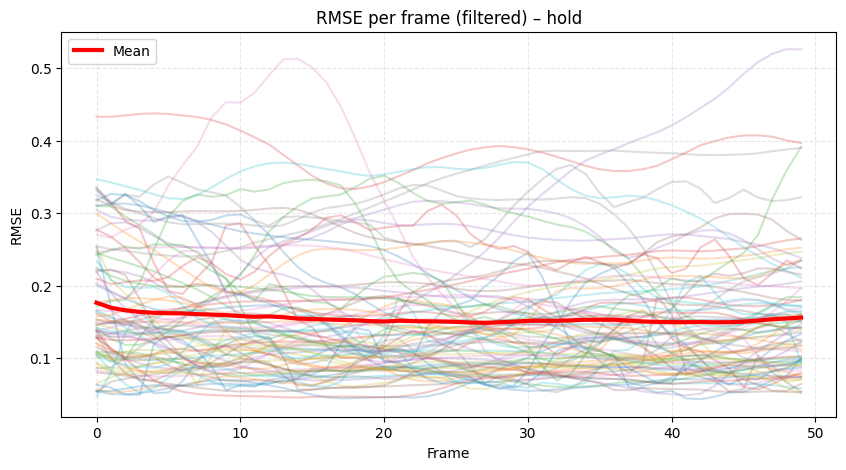

I0000 00:00:1765102363.653555  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.12586819, 0.12242622, 0.16568344, 0.16826005, 0.26501954,
       0.07830095, 0.16623504, 0.31214369, 0.08955399, 0.17086856,
       0.08193298, 0.14296153, 0.24936409, 0.20989144, 0.26834702,
       0.1048649 , 0.28916468, 0.3331673 , 0.12569337, 0.14858625,
       0.21404249, 0.24250813, 0.14391299, 0.13708814, 0.11066031,
       0.24926475, 0.1033304 , 0.12737303, 0.10672731, 0.07404811,
       0.20855013, 0.08699046, 0.12852243, 0.18334328, 0.09548913,
       0.17184222, 0.13929576, 0.28108019, 0.16679801, 0.33288398,
       0.07962746, 0.1013913 , 0.09378773, 0.38892798, 0.3041787 ,
       0.19211877, 0.13497885, 0.10893917, 0.11854152, 0.10291975,
       0.17751867, 0.10918462, 0.17748496, 0.07384436, 0.17364841,
       0.19566843, 0.09194046, 0.13472364, 0.10373862, 0.14803213,
       0.0875648 , 0.18066124, 0.21582294, 0.24577525, 0.16153267,
       0.10954542, 0.22773986, 0.12795994, 0.08597688, 0.1448898 ,
       0.11744758, 0.11502182, 0.21152149, 0.10374015, 0.1447

I0000 00:00:1765102363.654323  449270 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/19 [00:00<?, ?it/s]W0000 00:00:1765102363.700032  449257 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102363.727908  449263 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 19/19 [00:00<00:00, 35.22it/s]


➡️ 1 trajectoires extraites

📊 RMSE moyen avant filtrage : 0.0001
📈 RMSE max : 0.0001
🧹 Filtrage : 1/1 vidéos gardées (< 0.35)

📊 RMSE moyen après filtrage : 0.0001
📈 RMSE max : 0.0001
📉 RMSE min : 0.0001

💾 Dataset + DMP sauvegardés dans datasets_2D/punch.joblib


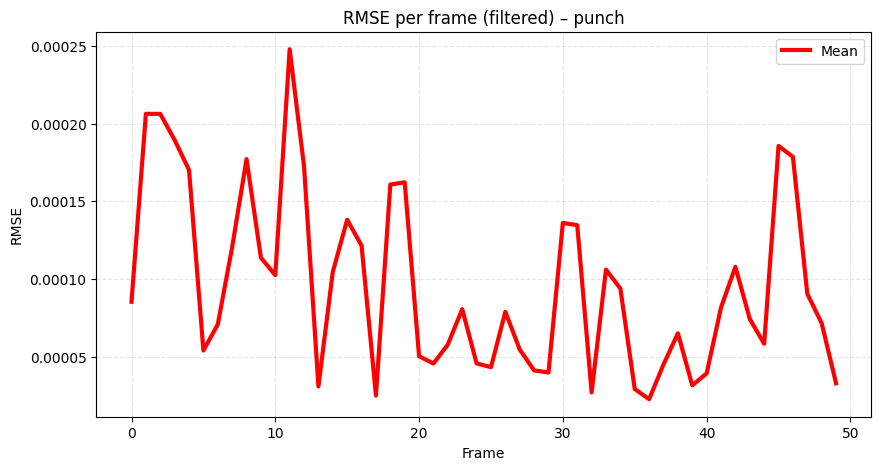

I0000 00:00:1765102364.311731  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102364.312739  449321 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)


(array([0.00011231]), array([[8.53908419e-05, 2.06255258e-04, 2.06228881e-04, 1.89400822e-04,
        1.70130008e-04, 5.40291081e-05, 7.07926326e-05, 1.20502289e-04,
        1.77142015e-04, 1.13695555e-04, 1.02505200e-04, 2.47810601e-04,
        1.72349249e-04, 3.09590765e-05, 1.04585611e-04, 1.38136939e-04,
        1.21541791e-04, 2.50648655e-05, 1.60756547e-04, 1.62225870e-04,
        5.03515241e-05, 4.56768399e-05, 5.78357009e-05, 8.06345074e-05,
        4.57701957e-05, 4.33120339e-05, 7.89357761e-05, 5.46557233e-05,
        4.12431610e-05, 3.99023150e-05, 1.36113092e-04, 1.34624718e-04,
        2.70946175e-05, 1.06071311e-04, 9.38515310e-05, 2.92509342e-05,
        2.27023767e-05, 4.50610769e-05, 6.50833409e-05, 3.16167473e-05,
        3.92951345e-05, 8.16829853e-05, 1.07860496e-04, 7.43495719e-05,
        5.83745020e-05, 1.85606767e-04, 1.78604643e-04, 9.05251745e-05,
        7.15658299e-05, 3.29563853e-05]]), <__main__.DMPVector object at 0x7d463afec940>, array([[[ 0.40294047, -0

  0%|          | 0/42 [00:00<?, ?it/s]W0000 00:00:1765102364.368303  449304 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102364.391499  449313 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 42/42 [00:01<00:00, 39.78it/s]
I0000 00:00:1765102365.393183  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/32 [00:00<?, ?it/s]I0000 00:00:1765102365.394362  449372 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765102365.441441  449357 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102365.468008  449359 inference_feedback_ma

➡️ 18 trajectoires extraites

📊 RMSE moyen avant filtrage : 1.1435
📈 RMSE max : 6.1941
🧹 Filtrage : 0/18 vidéos gardées (< 0.35)
⚠️ Aucune vidéo n'a passé le filtrage pour le label 'point'
(None, None, None, None, [], array([2.05630284, 0.9558392 , 0.58023181, 1.01131514, 1.00839705,
       0.83401417, 0.90379425, 0.65810762, 0.70525199, 6.19407156,
       0.81510052, 0.73457354, 0.63261696, 0.78984672, 0.64803567,
       0.5299053 , 0.8382289 , 0.68787872]))
⚠️ Seulement 1 vidéos disponibles pour 'wave', mais 100 demandées.
👉 Retour de TOUTES les vidéos disponibles.

🔎 Extraction vidéos du label 'wave' ...


  0%|          | 0/43 [00:00<?, ?it/s]W0000 00:00:1765102388.025910  450227 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102388.055330  450240 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 43/43 [00:00<00:00, 43.34it/s]


➡️ 1 trajectoires extraites

📊 RMSE moyen avant filtrage : 0.0007
📈 RMSE max : 0.0007
🧹 Filtrage : 1/1 vidéos gardées (< 0.35)

📊 RMSE moyen après filtrage : 0.0007
📈 RMSE max : 0.0007
📉 RMSE min : 0.0007

💾 Dataset + DMP sauvegardés dans datasets_2D/wave.joblib


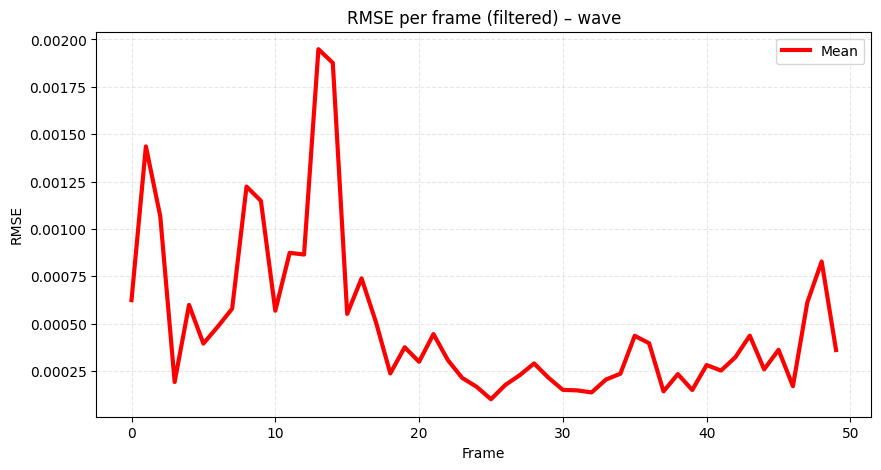

I0000 00:00:1765102389.095906  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102389.097110  450295 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)


(array([0.00065028]), array([[0.00062465, 0.00143543, 0.00106738, 0.00019292, 0.0005996 ,
        0.00039566, 0.00048465, 0.00057979, 0.00122367, 0.00114857,
        0.00056903, 0.00087419, 0.00086529, 0.00194818, 0.00187611,
        0.00055203, 0.00073952, 0.00050884, 0.00023812, 0.00037621,
        0.00029956, 0.00044564, 0.00030868, 0.00021439, 0.00016779,
        0.00010207, 0.00017737, 0.00022873, 0.00029083, 0.00021546,
        0.0001514 , 0.00014858, 0.00013805, 0.00020595, 0.00023647,
        0.00043664, 0.00039731, 0.00014354, 0.00023446, 0.00015059,
        0.0002825 , 0.00025321, 0.00032372, 0.00043737, 0.00025975,
        0.00036255, 0.00017074, 0.0006119 , 0.00082855, 0.00036149]]), <__main__.DMPVector object at 0x7d46160843d0>, array([[[ 0.34813504, -0.02615756,  0.47612041, ...,  0.32307895,
         -1.23256422, -0.28903671],
        [ 0.3676393 , -0.0666642 ,  0.49426349, ...,  0.33398015,
         -1.23908395, -0.2941575 ],
        [ 0.37179478, -0.0925519 ,  0.497693

  0%|          | 0/77 [00:00<?, ?it/s]W0000 00:00:1765102389.152630  450277 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102389.180940  450288 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 77/77 [00:01<00:00, 43.56it/s]
I0000 00:00:1765102390.887615  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102390.888644  450346 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/52 [00:00<?, ?it/s]W0000 00:00:1765102390.945344  450328 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102390.973151  450337 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip GESRes_filtered_gestures/show/1805_Lecturer2_show.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765102463.188820  452917 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/42 [00:00<?, ?it/s]W0000 00:00:1765102463.250584  452904 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102463.278857  452907 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 42/42 [00:01<00:00, 39.70it/s]
I0000 00:00:1765102464.273432  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102464.274650  452968 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/61 [00:00<?, ?it/s]W0000 00:00:1765102464.327745  452955 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip GESRes_filtered_gestures/show/1923_Lecturer2_show.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/54 [00:00<?, ?it/s]W0000 00:00:1765102499.571814  453773 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102499.597738  453781 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 54/54 [00:01<00:00, 43.64it/s]
I0000 00:00:1765102500.784838  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102500.785726  453839 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/154 [00:00<?, ?it/s]W0000 00:00:1765102500.830256  453823 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102500.853245  453832 inference_feedback_m

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip GESRes_filtered_gestures/show/2231_Lecturer3_show.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/30 [00:00<?, ?it/s]W0000 00:00:1765102516.095163  454087 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102516.121362  454093 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 30/30 [00:00<00:00, 39.05it/s]
I0000 00:00:1765102516.841363  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102516.842547  454151 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/73 [00:00<?, ?it/s]W0000 00:00:1765102516.899085  454134 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102516.924792  454142 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip GESRes_filtered_gestures/show/1925_Lecturer2_show.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765102527.397855  454564 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/23 [00:00<?, ?it/s]W0000 00:00:1765102527.452735  454546 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102527.483392  454556 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 23/23 [00:00<00:00, 39.84it/s]
I0000 00:00:1765102528.007559  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102528.008397  454615 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/56 [00:00<?, ?it/s]W0000 00:00:1765102528.063256  454598 inference_feedback_manager.cc:114] Feedba

➡️ 86 trajectoires extraites

📊 RMSE moyen avant filtrage : 0.7351
📈 RMSE max : 11.6210
🧹 Filtrage : 15/86 vidéos gardées (< 0.35)

📊 RMSE moyen après filtrage : 0.2476
📈 RMSE max : 0.2916
📉 RMSE min : 0.2073

💾 Dataset + DMP sauvegardés dans datasets_2D/show.joblib


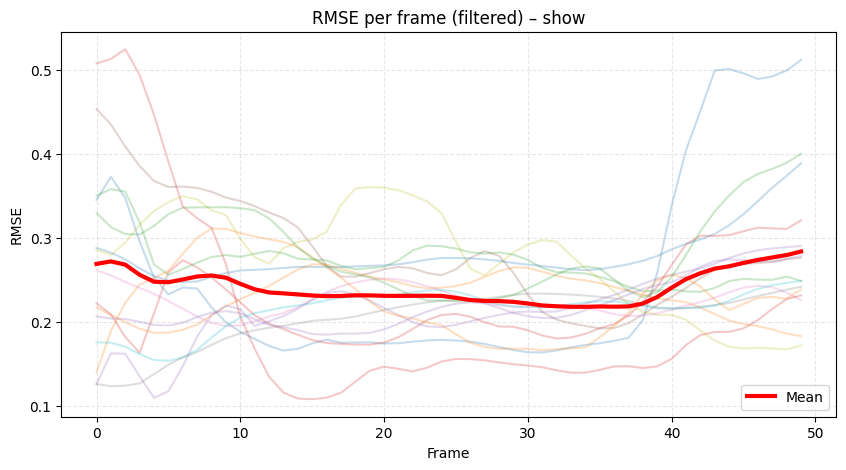

I0000 00:00:1765102538.981212  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102538.982289  454921 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)


(array([0.28133646, 0.2317693 , 0.27202424, 0.22742889, 0.22044631,
       0.28949202, 0.22658935, 0.20734622, 0.28151019, 0.21546676,
       0.28053032, 0.2322539 , 0.29157053, 0.23602335, 0.22087341]), array([[0.34480916, 0.37250951, 0.34740369, 0.29529817, 0.252572  ,
        0.23258868, 0.24076616, 0.23955147, 0.21707359, 0.19927853,
        0.18810815, 0.1795715 , 0.17131819, 0.16574383, 0.16786134,
        0.17421088, 0.1787263 , 0.17515991, 0.17535666, 0.17554058,
        0.17411945, 0.17449473, 0.17632564, 0.17780211, 0.17843618,
        0.1777395 , 0.17632128, 0.17371334, 0.16990562, 0.16641379,
        0.16374684, 0.16342597, 0.16584395, 0.16960341, 0.17244804,
        0.17444548, 0.17743691, 0.18087789, 0.20195084, 0.25865204,
        0.33826756, 0.40417808, 0.45092577, 0.49900663, 0.50078879,
        0.49554769, 0.48883206, 0.4919574 , 0.49900534, 0.511544  ],
       [0.2173089 , 0.20788991, 0.19969541, 0.19166249, 0.18683483,
        0.18722263, 0.19048093, 0.19665948, 0.2

  0%|          | 0/32 [00:00<?, ?it/s]W0000 00:00:1765102539.044329  454909 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102539.082424  454916 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 32/32 [00:00<00:00, 41.48it/s]
I0000 00:00:1765102539.788684  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102539.790269  454972 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/25 [00:00<?, ?it/s]W0000 00:00:1765102539.841660  454955 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102539.863552  454964 inference_feedback_ma

➡️ 3 trajectoires extraites

📊 RMSE moyen avant filtrage : 0.4059
📈 RMSE max : 0.6075
🧹 Filtrage : 2/3 vidéos gardées (< 0.35)

📊 RMSE moyen après filtrage : 0.0306
📈 RMSE max : 0.0306
📉 RMSE min : 0.0306

💾 Dataset + DMP sauvegardés dans datasets_2D/soft.joblib


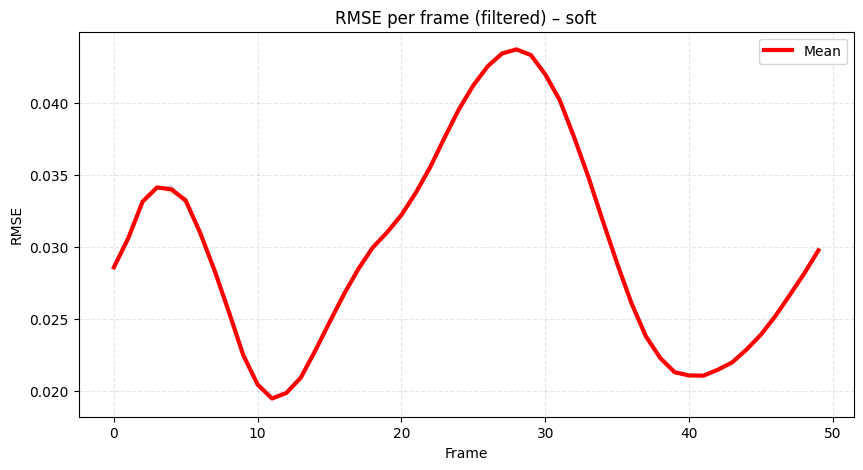

I0000 00:00:1765102540.985907  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.03062643, 0.03062604]), array([[0.02851355, 0.03070299, 0.03310334, 0.03398238, 0.0342346 ,
        0.03294923, 0.03115734, 0.02825513, 0.02546697, 0.02246427,
        0.02044788, 0.0193969 , 0.0198642 , 0.02086591, 0.02283461,
        0.02461051, 0.02686069, 0.02834537, 0.02995163, 0.03099351,
        0.03222088, 0.03372139, 0.03554988, 0.03755403, 0.03958091,
        0.04119376, 0.04255228, 0.04342625, 0.04369943, 0.0433458 ,
        0.04192055, 0.04027654, 0.03756334, 0.03490869, 0.03175732,
        0.02886055, 0.02606583, 0.02373229, 0.02232343, 0.02120236,
        0.02110893, 0.02099752, 0.02146647, 0.02194208, 0.02286455,
        0.02386092, 0.02516801, 0.02667601, 0.02805218, 0.02977432],
       [0.02861853, 0.03047826, 0.03317176, 0.03424529, 0.0337405 ,
        0.03344751, 0.03076727, 0.02845408, 0.02545301, 0.02244687,
        0.02037744, 0.0194968 , 0.01980782, 0.02092531, 0.02269257,
        0.02489275, 0.02652544, 0.02854557, 0.02991989, 0.0309924 ,
        0.032

I0000 00:00:1765102540.986702  455074 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/49 [00:00<?, ?it/s]W0000 00:00:1765102541.035936  455058 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102541.062523  455068 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 49/49 [00:01<00:00, 42.96it/s]
I0000 00:00:1765102542.157215  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102542.158562  455125 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/31 [00:00<?, ?it/s]W0000 00:00:1765102542.210928  455108 inference_feedback_manager.cc:114] Feedba

➡️ 9 trajectoires extraites

📊 RMSE moyen avant filtrage : 0.2385
📈 RMSE max : 0.3769
🧹 Filtrage : 7/9 vidéos gardées (< 0.35)

📊 RMSE moyen après filtrage : 0.1814
📈 RMSE max : 0.3520
📉 RMSE min : 0.1100

💾 Dataset + DMP sauvegardés dans datasets_2D/present.joblib


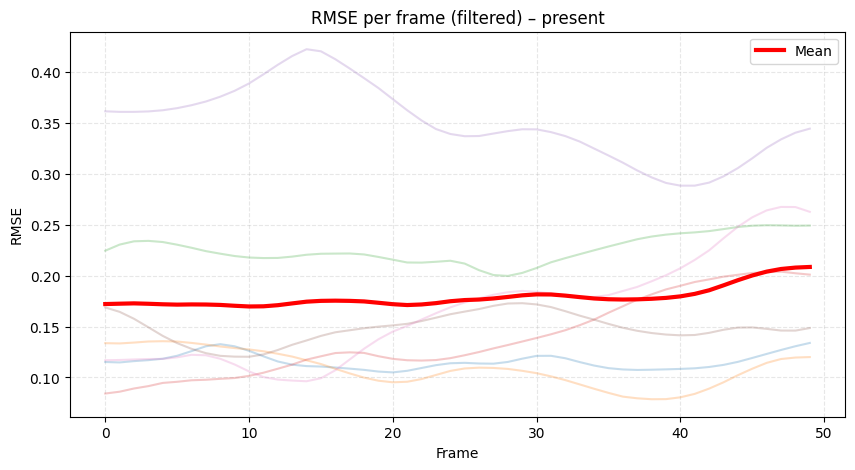

(array([0.11603632, 0.10995675, 0.22615203, 0.14383079, 0.35199814,
       0.1490727 , 0.17292767]), array([[0.11515801, 0.11473426, 0.11603411, 0.11698057, 0.11836438,
        0.12126492, 0.12582951, 0.13059864, 0.13267184, 0.13055947,
        0.12612696, 0.12074255, 0.1156711 , 0.1125332 , 0.11114302,
        0.11068932, 0.10976326, 0.10865198, 0.10743209, 0.10576975,
        0.10497089, 0.10651594, 0.1092821 , 0.11205647, 0.11393742,
        0.11433162, 0.11369099, 0.11351566, 0.11521667, 0.11842138,
        0.12117251, 0.12124257, 0.11884285, 0.11507466, 0.11167267,
        0.10913184, 0.10783663, 0.10735588, 0.10758826, 0.10793865,
        0.10836723, 0.10897141, 0.11027451, 0.11232856, 0.11530885,
        0.11913439, 0.12307398, 0.1269669 , 0.13064447, 0.13386935],
       [0.13365575, 0.133384  , 0.13423704, 0.13528913, 0.13557435,
        0.13524721, 0.13389126, 0.13227524, 0.13039225, 0.12882684,
        0.12749121, 0.12569695, 0.12326139, 0.12048678, 0.116829  ,
        0.1131

I0000 00:00:1765102553.109740  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/49 [00:00<?, ?it/s]I0000 00:00:1765102553.110592  455534 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765102553.154384  455519 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102553.181523  455523 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 49/49 [00:01<00:00, 46.01it/s]
I0000 00:00:1765102554.196496  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102554.197360  455585 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ Skip GESRes_filtered_gestures/hand/2120_Lecturer3_hand_flip.mp4 : ValueError("If mode is 'interp', window_length must be less than or equal to the size of x.")


I0000 00:00:1765102555.247153  455688 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/16 [00:00<?, ?it/s]W0000 00:00:1765102555.300624  455678 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102555.326014  455675 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 16/16 [00:00<00:00, 33.48it/s]
I0000 00:00:1765102555.753215  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102555.754710  455740 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/24 [00:00<?, ?it/s]W0000 00:00:1765102555.804693  455730 inference_feedback_manager.cc:114] Feedba

➡️ 11 trajectoires extraites

📊 RMSE moyen avant filtrage : 0.3665
📈 RMSE max : 1.2546
🧹 Filtrage : 8/11 vidéos gardées (< 0.35)

📊 RMSE moyen après filtrage : 0.2076
📈 RMSE max : 0.3310
📉 RMSE min : 0.0876

💾 Dataset + DMP sauvegardés dans datasets_2D/hand.joblib


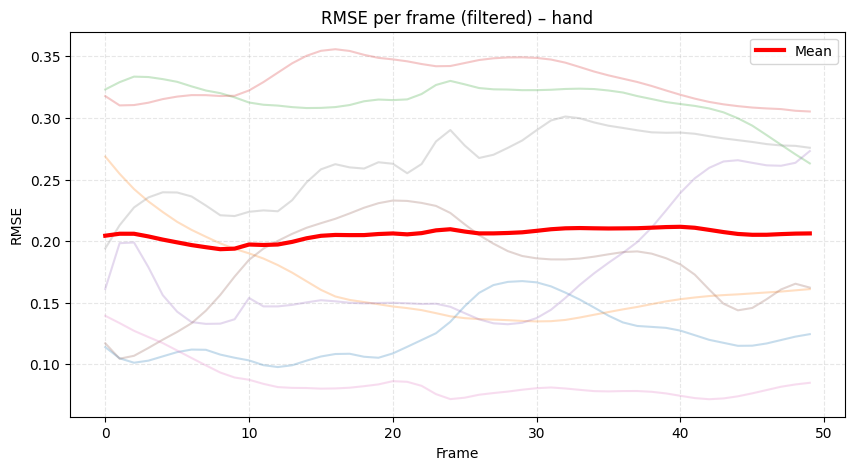

(array([0.12522092, 0.16925493, 0.31487399, 0.33100133, 0.18357265,
       0.18381896, 0.08761293, 0.26520441]), array([[0.1139836 , 0.1049213 , 0.10135108, 0.10301936, 0.10650832,
        0.10996339, 0.11202482, 0.11184363, 0.10794149, 0.10538537,
        0.10321788, 0.09937891, 0.09782383, 0.09930622, 0.1030446 ,
        0.10640958, 0.10841074, 0.10862029, 0.10618165, 0.10538316,
        0.10889353, 0.11426593, 0.11976412, 0.12526427, 0.13456645,
        0.14722863, 0.15806242, 0.16437614, 0.16695528, 0.16759374,
        0.16658117, 0.16332153, 0.15825592, 0.15260236, 0.14611899,
        0.13951193, 0.13405859, 0.13117825, 0.13042901, 0.12964421,
        0.12740354, 0.123688  , 0.11993343, 0.11749323, 0.1150637 ,
        0.11517926, 0.11698332, 0.11976624, 0.12252431, 0.12453449],
       [0.26866578, 0.25464507, 0.24228963, 0.23226433, 0.22364568,
        0.21568739, 0.20917521, 0.2035782 , 0.19820465, 0.19376326,
        0.19009626, 0.18590203, 0.1806106 , 0.17444595, 0.16745146,
  

In [40]:
def analyse_full_DESRes(): 
    for i in labels_DESRes:
        print(analyse_label_filtered(i, n = 100, target_len=50, n_basis=30)) 
    
analyse_full_DESRes()

### Analyse label from Jester Dataset


🔎 Extraction vidéos du label 'Stop Sign' ...


I0000 00:00:1765102565.280937  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102565.281709  456157 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102565.326270  456139 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102565.377285  456150 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.03it/s]
I0000 00:00:1765102566.232949  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102566.234039  456208 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Stop Sign/113666.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102571.082533  456450 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102571.114823  456453 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:01<00:00, 35.64it/s]
I0000 00:00:1765102572.099740  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102572.100766  456514 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102572.142619  456497 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102572.166453  456507 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Stop Sign/138503.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102583.943128  457129 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102583.968662  457133 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.25it/s]
I0000 00:00:1765102584.864705  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102584.866002  457189 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102584.920107  457181 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102584.946075  457182 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Stop Sign/129137.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102596.636827  457844 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102596.660765  457846 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 44.97it/s]
I0000 00:00:1765102597.435965  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102597.437242  457908 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102597.484472  457892 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102597.507190  457900 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Stop Sign/64798.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765102638.645208  460316 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102638.693807  460301 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102638.719509  460309 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 44.90it/s]
I0000 00:00:1765102639.512647  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102639.514483  460368 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102639.567178  460351 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Stop Sign/99358.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102660.143628  461528 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102660.172729  461539 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.90it/s]
I0000 00:00:1765102660.979376  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102660.980307  461596 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102661.020381  461582 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102661.045948  461585 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Stop Sign/110239.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765102672.720146  462261 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102672.769929  462248 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102672.794134  462254 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 46.56it/s]
I0000 00:00:1765102673.543000  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765102673.544791  462312 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765102673.607964  462295 inference_feedback_manager.cc:114] Feedba

➡️ 194 trajectoires extraites

📊 RMSE moyen avant filtrage : 0.4815
📈 RMSE max : 1.2120
🧹 Filtrage : 83/194 vidéos gardées (< 0.35)

📊 RMSE moyen après filtrage : 0.1512
📈 RMSE max : 0.3646
📉 RMSE min : 0.0530

💾 Dataset + DMP sauvegardés dans datasets_2D/Stop Sign.joblib


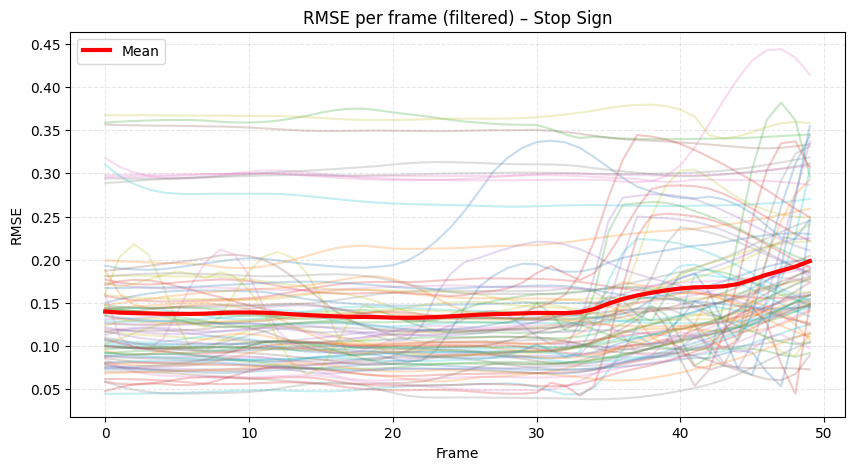

I0000 00:00:1765102746.664294  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.15750759, 0.09013909, 0.14233186, 0.16509217, 0.14412068,
       0.08729873, 0.13701664, 0.17039546, 0.15773505, 0.09969165,
       0.24642472, 0.21779117, 0.15247086, 0.11063374, 0.13940777,
       0.34614528, 0.29602903, 0.11352389, 0.15413306, 0.11635886,
       0.16014672, 0.13948874, 0.35539953, 0.08110123, 0.15870303,
       0.10848904, 0.31922239, 0.09208136, 0.18107147, 0.13678452,
       0.08528188, 0.12142239, 0.09345305, 0.21006509, 0.11830731,
       0.09335645, 0.08697504, 0.30327701, 0.12676122, 0.26942142,
       0.1154762 , 0.14963341, 0.12183033, 0.20078772, 0.14595522,
       0.09189087, 0.17018574, 0.2999522 , 0.14104851, 0.09541798,
       0.08689414, 0.11747317, 0.14217296, 0.0735366 , 0.11473055,
       0.1591049 , 0.12300645, 0.14249417, 0.12341924, 0.14035648,
       0.15026652, 0.1491678 , 0.1106947 , 0.12935888, 0.15542438,
       0.14384146, 0.29773941, 0.05303595, 0.36462467, 0.09599541,
       0.11863405, 0.11609191, 0.17131852, 0.13610823, 0.1042

I0000 00:00:1765102746.665621  466404 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102746.722441  466386 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102746.758994  466391 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 43.19it/s]
I0000 00:00:1765102747.553782  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102747.554957  466455 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102747.605880  466440 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Drumming Fingers/131742.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765102748.638060  466506 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102748.692229  466489 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102748.717236  466499 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.00it/s]
I0000 00:00:1765102749.561184  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102749.561937  466557 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102749.604279  466540 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Drumming Fingers/139396.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765102765.237450  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765102765.239113  467428 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765102765.291806  467417 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102765.317583  467420 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 43.13it/s]
I0000 00:00:1765102766.129798  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102766.131519  467479 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Drumming Fingers/73075.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765102767.161281  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765102767.163010  467530 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765102767.211970  467514 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102767.239475  467523 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 43.57it/s]
I0000 00:00:1765102768.058919  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102768.060718  467581 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Drumming Fingers/31057.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765102770.065576  467683 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102770.111883  467667 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102770.135801  467675 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.01it/s]
I0000 00:00:1765102771.021039  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102771.022179  467734 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102771.063541  467718 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Drumming Fingers/73135.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102807.753738  469815 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102807.782065  469820 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.45it/s]
I0000 00:00:1765102808.645364  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102808.646847  469882 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102808.697962  469868 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102808.723658  469875 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Drumming Fingers/82183.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765102842.367822  471770 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102842.411570  471752 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102842.438074  471760 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.72it/s]
I0000 00:00:1765102843.260430  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102843.261772  471821 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102843.306661  471807 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Drumming Fingers/118137.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765102896.645826  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102896.646661  474836 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102896.704481  474818 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102896.739349  474826 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.77it/s]
I0000 00:00:1765102897.568250  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102897.570219  474887 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Drumming Fingers/33826.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765102900.484515  475040 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102900.538896  475022 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102900.568200  475032 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 45.01it/s]
I0000 00:00:1765102901.331894  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102901.333317  475091 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102901.391593  475075 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Drumming Fingers/121608.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102904.958556  475281 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102904.996569  475292 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.42it/s]
I0000 00:00:1765102905.818828  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102905.819722  475346 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102905.866156  475339 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102905.891316  475338 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Drumming Fingers/54203.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102923.789846  476360 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102923.818451  476364 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 38.78it/s]
I0000 00:00:1765102924.725006  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102924.726712  476425 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102924.787088  476419 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102924.811141  476414 inference_feedback_ma

➡️ 190 trajectoires extraites

📊 RMSE moyen avant filtrage : 0.4911
📈 RMSE max : 1.4697
🧹 Filtrage : 48/190 vidéos gardées (< 0.35)

📊 RMSE moyen après filtrage : 0.1400
📈 RMSE max : 0.3403
📉 RMSE min : 0.0718

💾 Dataset + DMP sauvegardés dans datasets_2D/Drumming Fingers.joblib


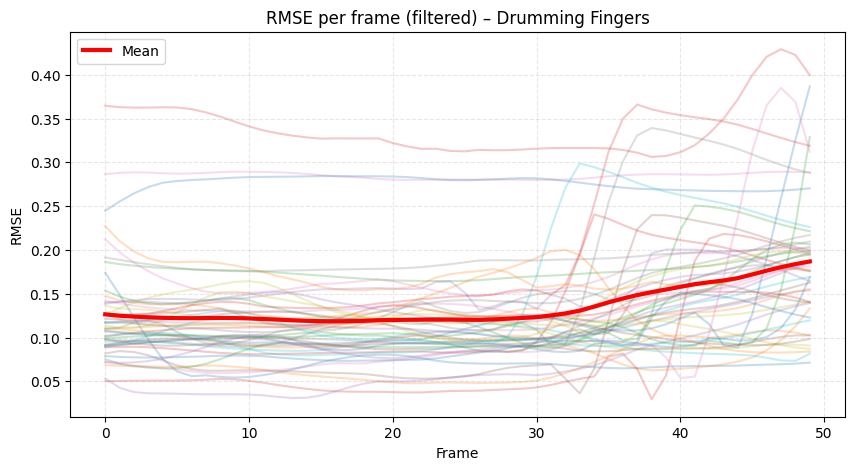

I0000 00:00:1765102928.598433  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.07654014, 0.09255115, 0.12216736, 0.14046113, 0.11777981,
       0.11466605, 0.28493335, 0.19362042, 0.12340023, 0.11188913,
       0.13241379, 0.12303367, 0.1761143 , 0.09936801, 0.07180134,
       0.12920246, 0.14130575, 0.1262413 , 0.11390667, 0.10567276,
       0.27594015, 0.0735726 , 0.13385304, 0.12825617, 0.15841505,
       0.09071845, 0.17154008, 0.13748846, 0.1427722 , 0.17749931,
       0.10540497, 0.13748512, 0.11820337, 0.22389283, 0.14700984,
       0.12166317, 0.13774173, 0.14758271, 0.12097738, 0.10590228,
       0.08893925, 0.17113993, 0.13538386, 0.34034111, 0.10957829,
       0.11567476, 0.12040164, 0.18719787]), array([[0.17396491, 0.14866384, 0.12275013, ..., 0.06951131, 0.07021695,
        0.07139015],
       [0.11030945, 0.10947326, 0.10826287, ..., 0.09716275, 0.11271219,
        0.13333852],
       [0.09177675, 0.09398799, 0.09578812, ..., 0.20643589, 0.20847221,
        0.20643433],
       ...,
       [0.12149017, 0.12046414, 0.1199475 , ..., 0.092997

I0000 00:00:1765102928.599401  476629 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102928.665276  476611 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102928.693776  476619 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 46.66it/s]
I0000 00:00:1765102929.405994  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102929.406728  476680 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102929.451106  476665 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Thumb Up/57001.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765102930.406464  476731 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102930.476697  476722 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102930.501413  476724 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:01<00:00, 36.67it/s]
I0000 00:00:1765102931.453959  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102931.455408  476782 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102931.503900  476764 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Thumb Up/22605.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102937.573555  477122 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102937.595644  477132 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 43.40it/s]
I0000 00:00:1765102938.416625  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102938.417874  477191 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102938.473097  477174 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102938.495478  477183 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Thumb Up/128861.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765102951.070803  477905 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102951.122023  477888 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102951.158683  477898 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.65it/s]
I0000 00:00:1765102952.048906  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102952.050027  477956 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102952.100221  477941 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Thumb Up/144708.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765102968.583486  478861 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102968.612109  478868 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.92it/s]


⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Thumb Up/59790.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765102969.459218  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765102969.460229  478927 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765102969.518486  478917 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765102969.544203  478915 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 43.62it/s]
I0000 00:00:1765102970.337857  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765102970.338886  478978 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Thumb Up/23237.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103006.004629  480963 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103006.036821  480964 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.56it/s]
I0000 00:00:1765103006.897120  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103006.898307  481025 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103006.951648  481020 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103006.981357  481017 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Thumb Up/16305.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765103015.981898  481535 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103016.030145  481520 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103016.061582  481529 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.61it/s]
I0000 00:00:1765103016.886497  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103016.887420  481586 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103016.928344  481571 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Thumb Up/90297.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765103044.298545  483123 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103044.367689  483110 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103044.406102  483119 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 48.86it/s]
I0000 00:00:1765103045.076344  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103045.077275  483174 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103045.122180  483157 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Thumb Up/29275.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765103063.887526  484247 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103063.973752  484233 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103064.005075  484241 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.08it/s]
I0000 00:00:1765103064.828222  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103064.829404  484298 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103064.871833  484281 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Thumb Up/12438.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765103074.737416  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103074.738541  484859 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103074.799077  484856 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103074.821785  484851 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 44.01it/s]
I0000 00:00:1765103075.607989  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103075.609442  484910 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

➡️ 190 trajectoires extraites

📊 RMSE moyen avant filtrage : 0.5321
📈 RMSE max : 1.9638
🧹 Filtrage : 30/190 vidéos gardées (< 0.35)

📊 RMSE moyen après filtrage : 0.1318
📈 RMSE max : 0.3135
📉 RMSE min : 0.0658

💾 Dataset + DMP sauvegardés dans datasets_2D/Thumb Up.joblib


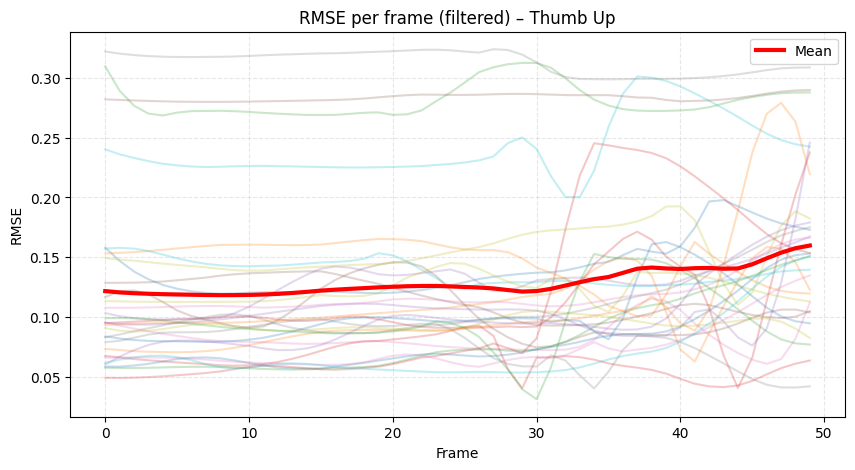

I0000 00:00:1765103110.718390  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.14329119, 0.14747492, 0.28164359, 0.11586919, 0.12918303,
       0.10577742, 0.08314302, 0.11119007, 0.15656448, 0.24236699,
       0.08354122, 0.11275269, 0.08736607, 0.06577126, 0.1072042 ,
       0.11672475, 0.11869518, 0.07832197, 0.09368169, 0.13840853,
       0.10329314, 0.1201379 , 0.10109332, 0.13452827, 0.10399079,
       0.28353585, 0.07641129, 0.31350714, 0.12338787, 0.07574406]), array([[0.1578962 , 0.14687491, 0.13795421, ..., 0.17822924, 0.17549405,
        0.17287067],
       [0.15314068, 0.15359319, 0.1542055 , ..., 0.1216832 , 0.12013945,
        0.11953227],
       [0.30959239, 0.28927177, 0.2768014 , ..., 0.28722555, 0.28775642,
        0.28789501],
       ...,
       [0.32212486, 0.32037982, 0.31916465, ..., 0.30802562, 0.3086316 ,
        0.30875157],
       [0.11314112, 0.11298961, 0.11269428, ..., 0.11686303, 0.11462885,
        0.1129116 ],
       [0.0614837 , 0.06408834, 0.06608944, ..., 0.14174853, 0.14721117,
        0.15044776]]), <__main__.DMPVect

I0000 00:00:1765103110.719565  486856 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103110.760128  486842 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103110.787354  486839 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.33it/s]
I0000 00:00:1765103111.701495  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103111.702390  486907 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103111.763389  486890 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Thumb Down/83630.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765103150.891346  489102 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103150.943464  489094 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103150.972251  489090 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 38.03it/s]
I0000 00:00:1765103151.892010  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103151.893261  489154 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103151.939717  489137 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Thumb Down/74868.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103170.015468  490162 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103170.038380  490171 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.08it/s]
I0000 00:00:1765103170.888405  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103170.889418  490229 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103170.942374  490213 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103170.965871  490221 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Thumb Down/112798.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765103191.562829  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765103191.563843  491403 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765103191.613893  491386 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103191.642324  491397 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 45.49it/s]
I0000 00:00:1765103192.404600  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103192.405665  491454 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Thumb Down/146238.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103204.372599  492106 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103204.398287  492109 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.02it/s]
I0000 00:00:1765103205.289395  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103205.290759  492170 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103205.344802  492153 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103205.370686  492167 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Thumb Down/121952.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765103213.712249  492632 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103213.761150  492621 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103213.790194  492627 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.26it/s]
I0000 00:00:1765103214.641489  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103214.643044  492683 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103214.696947  492672 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Thumb Down/65856.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765103217.476283  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103217.477383  492836 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103217.522216  492831 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103217.548742  492830 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.31it/s]
I0000 00:00:1765103218.382354  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103218.383666  492887 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Thumb Down/129485.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103233.086384  493698 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103233.114693  493691 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:01<00:00, 36.29it/s]
I0000 00:00:1765103234.092188  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103234.093925  493758 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103234.140922  493740 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103234.168799  493747 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Thumb Down/141693.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765103234.843590  493809 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103234.894136  493794 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103234.922914  493803 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 38.91it/s]
I0000 00:00:1765103235.827776  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103235.829449  493860 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103235.896717  493846 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Thumb Down/133486.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765103241.286735  494167 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103241.350374  494153 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103241.378895  494149 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 37.61it/s]
I0000 00:00:1765103242.300026  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103242.301525  494218 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103242.349609  494202 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Thumb Down/19144.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765103244.073882  494320 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103244.128134  494307 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103244.152697  494305 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 37.52it/s]
I0000 00:00:1765103245.089993  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103245.091340  494371 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103245.148827  494356 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Thumb Down/7972.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103266.380971  495530 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103266.414528  495540 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 45.74it/s]
I0000 00:00:1765103267.168682  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103267.169717  495596 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103267.221066  495582 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103267.252586  495586 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Thumb Down/71805.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765103268.222735  495647 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103268.269199  495633 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103268.299574  495640 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 44.45it/s]
I0000 00:00:1765103269.073565  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103269.074633  495699 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103269.120594  495685 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Thumb Down/73805.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103276.457494  496091 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103276.484205  496094 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 43.01it/s]
I0000 00:00:1765103277.292538  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103277.293892  496160 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103277.340722  496145 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103277.367442  496156 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Thumb Down/36484.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103287.112704  496715 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103287.143542  496721 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.78it/s]
I0000 00:00:1765103287.995647  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103287.996887  496777 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103288.054871  496763 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103288.079101  496773 inference_feedback_ma

➡️ 186 trajectoires extraites

📊 RMSE moyen avant filtrage : 0.5998
📈 RMSE max : 1.6353
🧹 Filtrage : 22/186 vidéos gardées (< 0.35)

📊 RMSE moyen après filtrage : 0.1577
📈 RMSE max : 0.3777
📉 RMSE min : 0.0963

💾 Dataset + DMP sauvegardés dans datasets_2D/Thumb Down.joblib


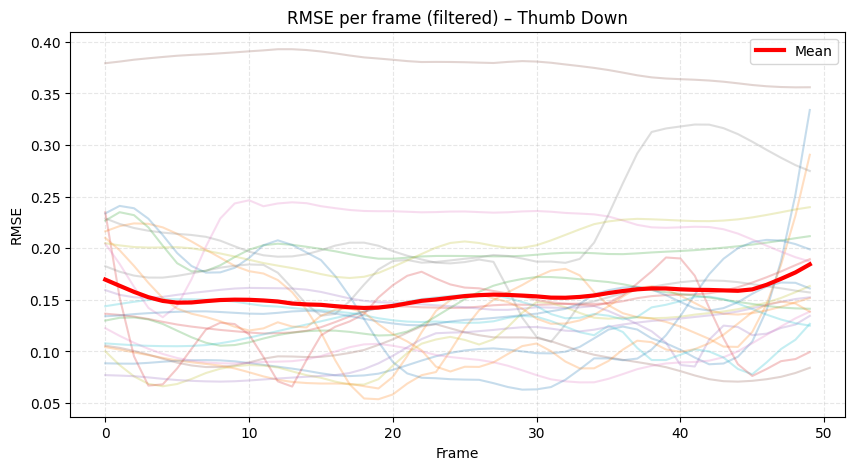

I0000 00:00:1765103293.686058  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.11378534, 0.15879391, 0.19869783, 0.1436383 , 0.1421413 ,
       0.0971693 , 0.0962803 , 0.18259411, 0.11365559, 0.12794413,
       0.1576878 , 0.12112819, 0.14081079, 0.13803335, 0.10976066,
       0.37771536, 0.22066134, 0.22100436, 0.20639024, 0.13374506,
       0.14194776, 0.12481562]), array([[0.08846909, 0.08816687, 0.0881015 , ..., 0.18780166, 0.25187475,
        0.3339396 ],
       [0.2163264 , 0.22139895, 0.22404164, ..., 0.18389377, 0.23142438,
        0.2905303 ],
       [0.2266928 , 0.23487394, 0.23201197, ..., 0.20740319, 0.20967193,
        0.21166821],
       ...,
       [0.10773833, 0.10682773, 0.10594284, ..., 0.13087296, 0.12728005,
        0.12495952],
       [0.13410105, 0.13481442, 0.13612032, ..., 0.16674646, 0.16646149,
        0.1610072 ],
       [0.20998046, 0.19800131, 0.18282697, ..., 0.14826729, 0.14643838,
        0.13850404]]), <__main__.DMPVector object at 0x7d4633a5dba0>, array([[[ 4.82358063e-01, -2.61370507e-02,  6.07547543e-01, ...,
        

I0000 00:00:1765103293.686965  497083 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103293.748892  497068 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103293.778197  497074 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.04it/s]
I0000 00:00:1765103294.589377  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103294.590232  497134 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103294.634906  497120 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Turning Hand Counterclockwise/76329.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765103313.629659  498206 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103313.681627  498192 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103313.711406  498197 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.99it/s]
I0000 00:00:1765103314.577468  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103314.578245  498257 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103314.619077  498250 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Turning Hand Counterclockwise/119167.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765103381.157459  501989 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103381.210609  501976 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103381.256332  501985 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 43.89it/s]
I0000 00:00:1765103382.029628  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103382.030493  502040 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103382.080702  502023 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Turning Hand Counterclockwise/44315.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765103414.470644  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765103414.472747  503835 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765103414.519583  503824 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103414.547141  503826 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.44it/s]
I0000 00:00:1765103415.429959  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103415.430887  503886 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Turning Hand Counterclockwise/87252.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103440.988659  505300 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103441.020746  505310 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.02it/s]
I0000 00:00:1765103441.832535  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765103441.833443  505366 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765103441.878476  505348 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103441.905499  505357 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Turning Hand Counterclockwise/82100.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765103460.419237  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765103460.420839  506390 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765103460.471789  506374 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103460.496991  506381 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.63it/s]
I0000 00:00:1765103461.363991  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103461.364955  506441 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

➡️ 195 trajectoires extraites

📊 RMSE moyen avant filtrage : 0.4961
📈 RMSE max : 1.7636
🧹 Filtrage : 69/195 vidéos gardées (< 0.35)

📊 RMSE moyen après filtrage : 0.1729
📈 RMSE max : 0.4308
📉 RMSE min : 0.0725

💾 Dataset + DMP sauvegardés dans datasets_2D/Turning Hand Counterclockwise.joblib


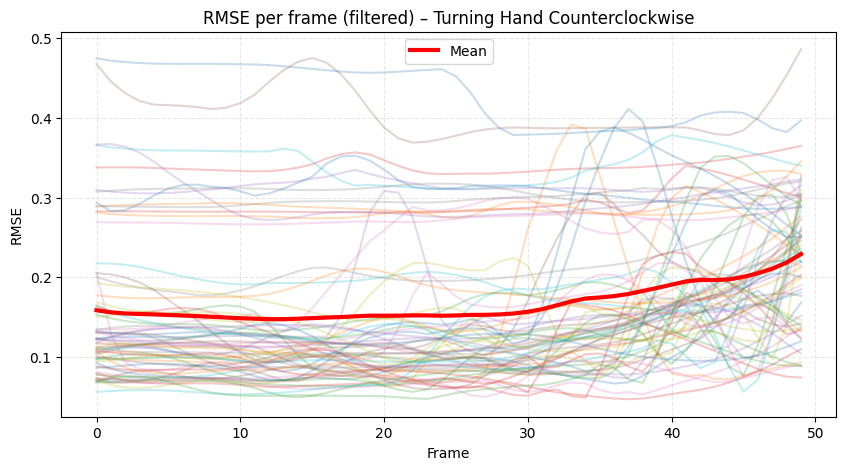

(array([0.104835  , 0.13200009, 0.12259513, 0.34012269, 0.16863427,
       0.41027534, 0.15123198, 0.12973329, 0.14624597, 0.11546223,
       0.43083739, 0.15843211, 0.17540971, 0.10280008, 0.11665597,
       0.15812953, 0.21866353, 0.21395891, 0.16840285, 0.18708325,
       0.18137005, 0.15605607, 0.10263091, 0.1031009 , 0.14301811,
       0.14087807, 0.07249528, 0.12543826, 0.10566599, 0.34314372,
       0.11882648, 0.2886994 , 0.09994481, 0.29237441, 0.31171   ,
       0.11497794, 0.15009584, 0.13001654, 0.15205051, 0.1309957 ,
       0.21640336, 0.28813269, 0.15632617, 0.09326504, 0.29828654,
       0.10833431, 0.27287871, 0.30786909, 0.12044108, 0.14554563,
       0.16100524, 0.15487005, 0.15923756, 0.12070635, 0.1066195 ,
       0.12639482, 0.07773312, 0.29845544, 0.13048616, 0.13490823,
       0.30827363, 0.18285503, 0.09735451, 0.12363108, 0.14516068,
       0.14815916, 0.1456765 , 0.14525645, 0.14013498]), array([[0.09262141, 0.08524092, 0.08109187, ..., 0.20452057, 0.20467957

I0000 00:00:1765103477.143453  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765103477.144346  507313 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765103477.188175  507296 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103477.214196  507299 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.18it/s]
I0000 00:00:1765103478.082266  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103478.083308  507364 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Turning Hand Clockwise/81134.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765103482.655267  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103482.656435  507619 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103482.712888  507601 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103482.739242  507611 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.58it/s]
I0000 00:00:1765103483.582420  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103483.584178  507670 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Turning Hand Clockwise/4522.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765103485.266636  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765103485.268176  507772 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765103485.317656  507755 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103485.345914  507768 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.88it/s]
I0000 00:00:1765103486.220268  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103486.221534  507823 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Turning Hand Clockwise/120996.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765103517.149681  509560 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103517.216732  509543 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103517.250038  509557 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.12it/s]
I0000 00:00:1765103518.058220  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103518.059664  509612 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103518.104866  509598 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Turning Hand Clockwise/122007.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103528.955676  510212 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103528.998254  510223 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.62it/s]
I0000 00:00:1765103529.814188  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103529.814956  510278 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103529.856876  510264 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103529.884136  510272 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Turning Hand Clockwise/93789.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103551.883260  511487 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103551.913869  511485 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 43.87it/s]
I0000 00:00:1765103552.687760  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Turning Hand Clockwise/29203.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765103552.688598  511554 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103552.740792  511536 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103552.771437  511546 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.96it/s]
I0000 00:00:1765103553.593084  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103553.594604  511605 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)


⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Turning Hand Clockwise/118299.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103553.649265  511591 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103553.678795  511594 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.09it/s]
I0000 00:00:1765103554.542665  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103554.543888  511656 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103554.596409  511643 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103554.623633  511646 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Turning Hand Clockwise/28512.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765103574.935153  512779 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103574.992344  512764 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103575.019195  512767 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.55it/s]
I0000 00:00:1765103575.911667  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103575.912857  512831 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103575.962023  512819 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Turning Hand Clockwise/35462.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103585.959606  513378 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103585.972982  513389 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 44.55it/s]
I0000 00:00:1765103586.767418  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103586.768430  513447 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103586.814322  513441 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103586.841836  513434 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Turning Hand Clockwise/120687.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103595.986577  513942 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103596.014869  513949 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 37.79it/s]
I0000 00:00:1765103596.925295  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103596.926230  514008 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103596.971043  513993 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103596.997441  514002 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Turning Hand Clockwise/134496.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765103604.177280  514421 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103604.234927  514404 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103604.263683  514416 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 44.14it/s]
I0000 00:00:1765103605.037773  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103605.038564  514472 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103605.082668  514457 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Turning Hand Clockwise/76104.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765103605.933116  514524 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103605.984045  514507 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103606.009853  514517 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 38.61it/s]
I0000 00:00:1765103606.937764  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103606.939790  514575 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103606.989817  514558 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Turning Hand Clockwise/125182.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765103641.283377  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103641.286114  516476 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103641.352544  516459 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103641.378645  516465 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.39it/s]
I0000 00:00:1765103642.200972  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103642.202652  516527 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

➡️ 187 trajectoires extraites

📊 RMSE moyen avant filtrage : 0.5177
📈 RMSE max : 1.2195
🧹 Filtrage : 37/187 vidéos gardées (< 0.35)

📊 RMSE moyen après filtrage : 0.1676
📈 RMSE max : 0.3699
📉 RMSE min : 0.0766

💾 Dataset + DMP sauvegardés dans datasets_2D/Turning Hand Clockwise.joblib


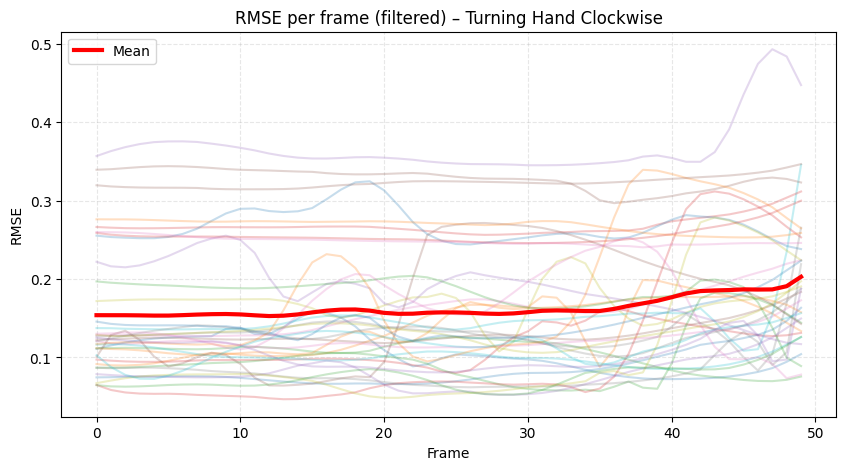

I0000 00:00:1765103660.609609  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.10869391, 0.14109023, 0.10624431, 0.11688861, 0.36989322,
       0.1313997 , 0.1611048 , 0.13450812, 0.17080414, 0.1528123 ,
       0.08878399, 0.14518714, 0.10493132, 0.26858034, 0.19102581,
       0.32848311, 0.12314914, 0.13099412, 0.13449106, 0.10120405,
       0.26956081, 0.20580198, 0.18276537, 0.14318217, 0.08298315,
       0.18368882, 0.16806198, 0.08465989, 0.12735466, 0.11693066,
       0.14736294, 0.26842013, 0.07655681, 0.25627488, 0.10628897,
       0.32334324, 0.24853935]), array([[0.11091625, 0.11527186, 0.11901678, ..., 0.08635941, 0.09441291,
        0.10418785],
       [0.09153079, 0.08995019, 0.08971126, ..., 0.15594364, 0.14422442,
        0.13357455],
       [0.11167095, 0.11193801, 0.1122823 , ..., 0.06971083, 0.07144378,
        0.07560853],
       ...,
       [0.12520318, 0.1231314 , 0.12149106, ..., 0.09517528, 0.0972426 ,
        0.18753969],
       [0.31972958, 0.31824637, 0.31737889, ..., 0.33842106, 0.34240195,
        0.34674071],
       [0.25996

I0000 00:00:1765103660.610456  517551 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103660.665056  517536 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103660.690788  517541 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 43.29it/s]
I0000 00:00:1765103661.492429  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103661.493375  517602 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103661.539031  517593 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Rolling Hand Backward/111377.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765103673.259589  518266 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103673.351693  518250 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103673.380229  518256 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.48it/s]
I0000 00:00:1765103674.227849  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103674.229435  518317 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103674.288737  518302 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Rolling Hand Backward/100884.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103681.455642  518714 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103681.477349  518726 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 43.10it/s]
I0000 00:00:1765103682.288385  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103682.289519  518781 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103682.347559  518764 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103682.373119  518777 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Rolling Hand Backward/116456.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103703.244567  519946 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103703.276931  519954 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 43.75it/s]
I0000 00:00:1765103704.067624  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103704.068914  520013 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103704.110649  520001 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103704.139011  520002 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Rolling Hand Backward/70500.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103713.168527  520506 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103713.193961  520510 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.09it/s]
I0000 00:00:1765103714.058608  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103714.059749  520574 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103714.109405  520559 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103714.139718  520568 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Rolling Hand Backward/92572.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103715.218989  520608 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103715.259001  520621 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.87it/s]
I0000 00:00:1765103716.069740  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103716.070853  520676 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103716.117512  520658 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103716.144211  520663 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Rolling Hand Backward/44204.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765103723.303693  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765103723.305341  521086 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765103723.365737  521074 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103723.392160  521076 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 44.54it/s]
I0000 00:00:1765103724.161902  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103724.163267  521137 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Rolling Hand Backward/7155.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765103744.964637  522310 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103745.020251  522292 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103745.048276  522303 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 38.58it/s]
I0000 00:00:1765103745.953014  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103745.953815  522361 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)


⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Rolling Hand Backward/147088.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103745.997995  522344 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103746.025596  522358 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 45.39it/s]
I0000 00:00:1765103746.799748  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103746.801195  522412 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103746.848683  522399 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103746.872065  522405 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Rolling Hand Backward/50810.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765103752.179652  522720 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103752.234658  522709 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103752.262390  522708 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 43.73it/s]
I0000 00:00:1765103753.068245  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103753.070270  522771 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103753.114511  522756 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Rolling Hand Backward/88362.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765103787.050619  524664 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103787.097678  524647 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103787.132081  524661 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 44.41it/s]
I0000 00:00:1765103787.915006  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103787.916279  524715 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103787.969768  524697 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Rolling Hand Backward/49564.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103791.740413  524903 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103791.766991  524914 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.11it/s]
I0000 00:00:1765103792.665769  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103792.666814  524970 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103792.711102  524954 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103792.738861  524965 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Rolling Hand Backward/59106.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103807.546936  525770 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103807.586834  525780 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.35it/s]
I0000 00:00:1765103808.451729  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103808.453480  525837 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103808.506109  525822 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103808.534419  525828 inference_feedback_ma

➡️ 188 trajectoires extraites

📊 RMSE moyen avant filtrage : 0.4786
📈 RMSE max : 1.1211
🧹 Filtrage : 82/188 vidéos gardées (< 0.35)

📊 RMSE moyen après filtrage : 0.1628
📈 RMSE max : 0.3979
📉 RMSE min : 0.0736

💾 Dataset + DMP sauvegardés dans datasets_2D/Rolling Hand Backward.joblib


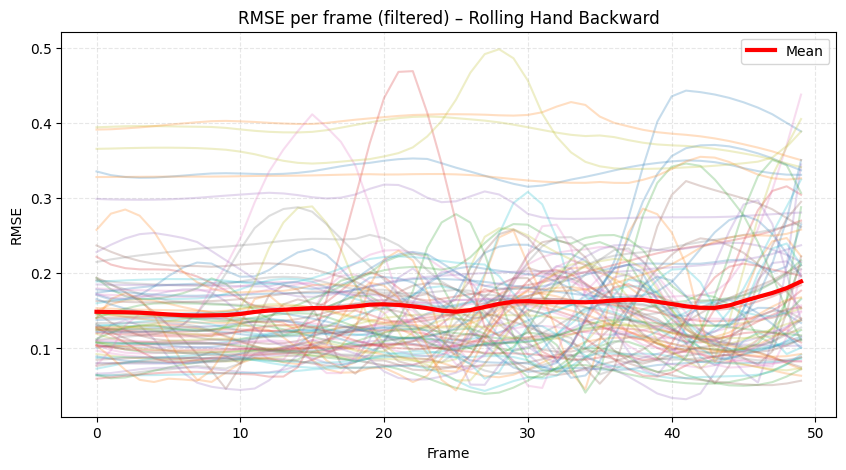

I0000 00:00:1765103843.515601  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.2428893 , 0.12203022, 0.16397009, 0.201383  , 0.11269942,
       0.12628553, 0.20548075, 0.09009214, 0.13069777, 0.13109379,
       0.15125076, 0.10427517, 0.11642026, 0.1217886 , 0.10963174,
       0.15216305, 0.13546931, 0.15389022, 0.13924952, 0.16031486,
       0.11094345, 0.13096637, 0.07724844, 0.15132076, 0.11945999,
       0.12416576, 0.15252629, 0.123615  , 0.16132181, 0.16943011,
       0.24279486, 0.16765927, 0.13985408, 0.14296747, 0.29220095,
       0.17238324, 0.11997716, 0.09859899, 0.38689553, 0.10485726,
       0.1989599 , 0.39794009, 0.19225527, 0.1317868 , 0.19699605,
       0.12667225, 0.11393472, 0.22623155, 0.15226985, 0.11575343,
       0.33605643, 0.15480076, 0.16833487, 0.13205298, 0.11270368,
       0.13342111, 0.1182934 , 0.17373569, 0.11330299, 0.07363377,
       0.19165093, 0.33020908, 0.1376638 , 0.12073282, 0.15445128,
       0.16215884, 0.20267741, 0.17833646, 0.15097848, 0.08430912,
       0.13036496, 0.20268394, 0.15676965, 0.18188825, 0.2088

I0000 00:00:1765103843.516752  527781 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103843.584130  527768 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103843.625538  527775 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 45.31it/s]
I0000 00:00:1765103844.356328  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103844.357570  527832 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103844.415713  527821 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Rolling Hand Forward/62207.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765103848.107891  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103848.108876  528037 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103848.166622  528020 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103848.191755  528030 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.55it/s]
I0000 00:00:1765103849.028935  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103849.030629  528088 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Rolling Hand Forward/51047.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765103867.523479  529112 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103867.570072  529098 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103867.595998  529100 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 43.79it/s]
I0000 00:00:1765103868.401465  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103868.402803  529163 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103868.456776  529148 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Rolling Hand Forward/142066.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103935.047012  532884 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103935.074351  532893 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 46.94it/s]
I0000 00:00:1765103935.793865  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103935.795124  532953 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103935.846851  532942 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103935.868606  532935 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Rolling Hand Forward/144339.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765103953.951303  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765103953.953016  533976 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765103954.008864  533961 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103954.041312  533964 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.63it/s]
I0000 00:00:1765103954.872292  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103954.873716  534027 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Rolling Hand Forward/118102.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103973.164224  535035 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103973.199887  535032 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.44it/s]
I0000 00:00:1765103974.079290  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103974.080333  535100 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103974.124535  535089 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103974.153219  535095 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Rolling Hand Forward/69995.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765103981.171449  535508 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103981.214022  535494 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765103981.251209  535499 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 43.22it/s]
I0000 00:00:1765103982.056624  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765103982.058167  535559 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765103982.113104  535541 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Rolling Hand Forward/21662.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104008.443628  537031 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104008.473408  537037 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.86it/s]
I0000 00:00:1765104009.338565  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765104009.339832  537094 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104009.384566  537077 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104009.411589  537080 inference_feedback_ma

➡️ 193 trajectoires extraites

📊 RMSE moyen avant filtrage : 0.4578
📈 RMSE max : 1.2180
🧹 Filtrage : 87/193 vidéos gardées (< 0.35)

📊 RMSE moyen après filtrage : 0.1534
📈 RMSE max : 0.3983
📉 RMSE min : 0.0699

💾 Dataset + DMP sauvegardés dans datasets_2D/Rolling Hand Forward.joblib


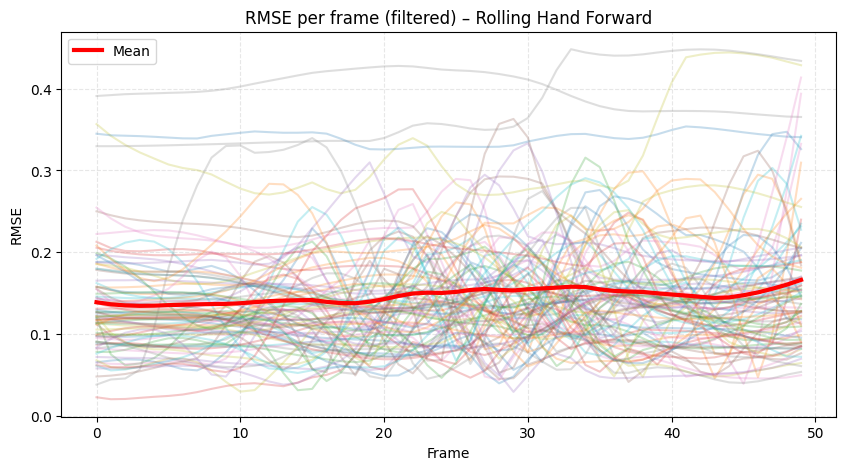

I0000 00:00:1765104026.460350  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.14399767, 0.17316931, 0.1330577 , 0.16602956, 0.13353283,
       0.10890573, 0.11897398, 0.11121462, 0.33000019, 0.14711998,
       0.14919704, 0.12825614, 0.13417593, 0.09830014, 0.17381622,
       0.17069205, 0.15202653, 0.13722211, 0.12816975, 0.13219476,
       0.17043014, 0.16038953, 0.11050491, 0.14379605, 0.12340515,
       0.10300254, 0.14320863, 0.1259658 , 0.09811002, 0.17136851,
       0.1138716 , 0.16603836, 0.13090597, 0.09728745, 0.14212054,
       0.14125829, 0.21771823, 0.3983221 , 0.1140975 , 0.13999873,
       0.15620397, 0.14777718, 0.12915187, 0.11244829, 0.1517289 ,
       0.17374408, 0.15418817, 0.10703637, 0.17712808, 0.15254138,
       0.15968987, 0.13668298, 0.11686735, 0.11874147, 0.162031  ,
       0.14179769, 0.10741767, 0.1645789 , 0.17310247, 0.14968624,
       0.1523771 , 0.18850297, 0.11740157, 0.13837261, 0.21511412,
       0.12926852, 0.12087588, 0.18461437, 0.13713511, 0.1429915 ,
       0.11299431, 0.21979684, 0.14759816, 0.18440779, 0.0699

I0000 00:00:1765104026.461465  538012 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104026.534444  537999 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104026.562964  538004 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.81it/s]
I0000 00:00:1765104027.395800  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765104027.397347  538064 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104027.447152  538047 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/133809.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104028.350485  538099 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104028.376399  538106 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 44.58it/s]
I0000 00:00:1765104029.150811  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765104029.152342  538166 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104029.197727  538152 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104029.223450  538156 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/26352.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765104048.129150  539239 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104048.179031  539223 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104048.203074  539229 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 43.81it/s]
I0000 00:00:1765104049.016461  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765104049.018234  539290 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104049.071091  539276 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/76473.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765104052.679654  539495 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104052.760161  539484 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104052.791000  539488 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.74it/s]
I0000 00:00:1765104053.587108  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765104053.588105  539546 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104053.629952  539531 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/17680.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765104074.566429  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765104074.567936  540724 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765104074.626965  540706 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104074.664911  540721 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.22it/s]
I0000 00:00:1765104075.543872  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765104075.545102  540775 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/76954.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765104079.237846  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765104079.238887  540980 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104079.282256  540964 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104079.312058  540975 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.33it/s]
I0000 00:00:1765104080.143808  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765104080.145312  541031 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: M

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/58121.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765104100.407248  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765104100.408195  542154 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104100.457749  542136 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104100.490416  542149 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.99it/s]
I0000 00:00:1765104101.293917  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765104101.295103  542205 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)


⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/56830.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104101.370513  542191 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104101.408996  542199 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.26it/s]
I0000 00:00:1765104102.275068  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765104102.276329  542256 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765104102.324781  542240 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104102.351942  542249 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/10026.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765104106.026847  542460 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104106.092672  542449 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104106.116955  542444 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 52.18it/s]
I0000 00:00:1765104106.774728  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765104106.776009  542511 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)


⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/106833.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104106.818645  542496 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104106.863024  542503 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.31it/s]
I0000 00:00:1765104107.678987  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765104107.679965  542562 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765104107.729808  542557 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104107.760759  542553 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/97030.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104132.017062  543931 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104132.044099  543938 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.57it/s]
I0000 00:00:1765104132.889263  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765104132.890277  543996 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104132.934985  543978 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104132.958899  543988 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/2509.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765104145.609899  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765104145.611431  544710 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104145.674928  544692 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104145.701332  544705 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.87it/s]
I0000 00:00:1765104146.562427  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765104146.563338  544761 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/4605.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765104165.966866  545835 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104166.029886  545822 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104166.056913  545820 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.63it/s]
I0000 00:00:1765104166.938192  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765104166.939845  545886 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104166.986622  545868 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/72326.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104173.340905  546229 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104173.365412  546240 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 43.20it/s]
I0000 00:00:1765104174.171042  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765104174.172008  546296 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104174.212350  546284 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104174.239484  546289 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/8307.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104183.358427  546792 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104183.386848  546801 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.05it/s]
I0000 00:00:1765104184.283826  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765104184.285688  546862 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104184.339450  546847 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104184.370246  546855 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/59070.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765104198.989766  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765104198.991322  547679 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104199.045586  547664 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104199.072202  547672 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 43.30it/s]
I0000 00:00:1765104199.879492  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765104199.880570  547730 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/18351.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765104201.734874  547832 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104201.819203  547817 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104201.845501  547824 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 44.35it/s]
I0000 00:00:1765104202.597273  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765104202.598652  547883 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104202.647210  547867 inference_feedback_manager.cc:114] Feedba

➡️ 184 trajectoires extraites

📊 RMSE moyen avant filtrage : 0.5395
📈 RMSE max : 1.9286
🧹 Filtrage : 33/184 vidéos gardées (< 0.35)

📊 RMSE moyen après filtrage : 0.1462
📈 RMSE max : 0.3150
📉 RMSE min : 0.0866

💾 Dataset + DMP sauvegardés dans datasets_2D/Pushing Hand Away.joblib


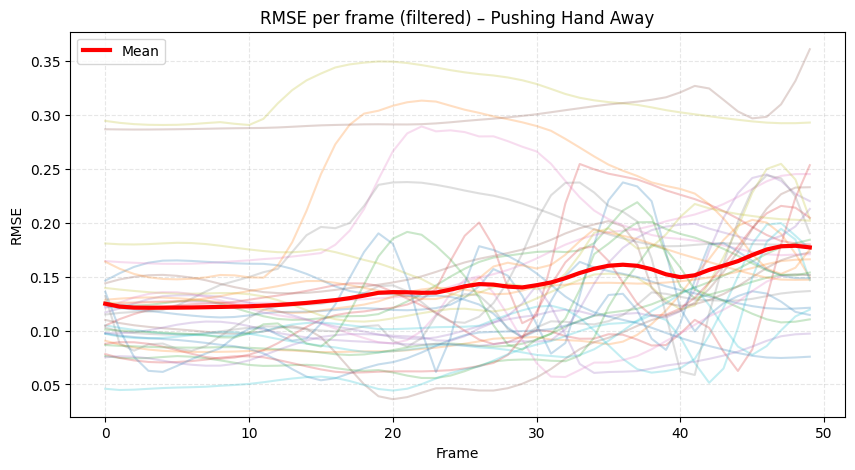

I0000 00:00:1765104209.139584  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.13505682, 0.1105815 , 0.14645835, 0.16189853, 0.13796849,
       0.11186639, 0.16699857, 0.11210901, 0.1459247 , 0.11332254,
       0.1416438 , 0.13758882, 0.10944094, 0.12257335, 0.13244782,
       0.15538246, 0.20862023, 0.18666229, 0.31498365, 0.09474824,
       0.10732985, 0.23463579, 0.09465908, 0.11706   , 0.08685183,
       0.2999582 , 0.11374825, 0.15427217, 0.17603205, 0.08658264,
       0.11501992, 0.15058536, 0.1416361 ]), array([[0.12223819, 0.12073043, 0.11937714, ..., 0.12679468, 0.11725825,
        0.11439536],
       [0.09051731, 0.08695932, 0.08419681, ..., 0.18956945, 0.17137017,
        0.14911129],
       [0.12604103, 0.12375148, 0.12315687, ..., 0.1515113 , 0.1521006 ,
        0.15142673],
       ...,
       [0.13596049, 0.10053355, 0.07556595, ..., 0.07451624, 0.0749851 ,
        0.07569687],
       [0.12568076, 0.12578018, 0.12595422, ..., 0.14720885, 0.14694714,
        0.14709835],
       [0.10089498, 0.10003052, 0.09912505, ..., 0.15162215, 0.1511358

I0000 00:00:1765104209.140730  548242 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104209.219431  548230 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104209.248936  548235 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.99it/s]
I0000 00:00:1765104210.091429  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765104210.092466  548293 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104210.143916  548279 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Shaking Hand/110038.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104234.380328  549653 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104234.410391  549661 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 47.10it/s]
I0000 00:00:1765104235.133860  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765104235.135150  549722 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)


⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Shaking Hand/88437.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104235.202566  549710 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104235.233968  549709 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.17it/s]
I0000 00:00:1765104236.107365  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765104236.108593  549774 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104236.158450  549758 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104236.188480  549768 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Shaking Hand/65690.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765104238.784706  549927 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104238.839108  549919 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104238.869260  549913 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 43.11it/s]
I0000 00:00:1765104239.674838  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765104239.676219  549978 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104239.722841  549965 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Shaking Hand/30585.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104243.312520  550175 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104243.337484  550179 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 45.84it/s]
I0000 00:00:1765104244.083619  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765104244.085033  550233 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104244.135618  550219 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104244.162789  550225 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Shaking Hand/36264.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765104252.140727  550694 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104252.204812  550677 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104252.233457  550686 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 45.06it/s]
I0000 00:00:1765104252.995283  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765104252.996647  550745 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104253.041433  550729 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Shaking Hand/72554.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104260.375674  551136 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104260.397963  551145 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 44.26it/s]
I0000 00:00:1765104261.193133  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Shaking Hand/68569.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765104261.194399  551204 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104261.248496  551190 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104261.279462  551196 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.62it/s]
I0000 00:00:1765104262.088089  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765104262.089462  551255 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104262.139431  551241 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Shaking Hand/18826.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104286.474344  552621 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104286.499915  552628 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.23it/s]
I0000 00:00:1765104287.386989  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765104287.388169  552685 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104287.429064  552670 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104287.457067  552678 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Shaking Hand/133876.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104300.691558  553384 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104300.716220  553392 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 38.62it/s]
I0000 00:00:1765104301.596051  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765104301.597490  553452 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104301.643482  553448 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104301.668857  553440 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Shaking Hand/62029.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765104306.151810  553711 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104306.199772  553694 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104306.223574  553705 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.57it/s]
I0000 00:00:1765104307.067151  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765104307.068247  553762 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104307.116790  553744 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Shaking Hand/110713.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104326.874807  554871 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104326.903892  554870 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.46it/s]
I0000 00:00:1765104327.722361  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765104327.723558  554937 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104327.767815  554920 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104327.795825  554929 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Shaking Hand/2485.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104332.233558  555176 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104332.271556  555174 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 43.82it/s]
I0000 00:00:1765104333.067124  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765104333.068805  555243 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104333.116301  555233 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104333.146148  555234 inference_feedback_ma

⚠️ landmarks_2_table a échoué: AttributeError("'NoneType' object has no attribute 'landmark'")
please replace the video
⚠️ Skip Jester_filtered_gestures/Shaking Hand/32552.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104336.571783  555442 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104336.603168  555440 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.92it/s]
I0000 00:00:1765104337.391599  402086 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765104337.392572  555498 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765104337.435551  555483 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765104337.462350  555491 inference_feedback_ma

➡️ 187 trajectoires extraites

📊 RMSE moyen avant filtrage : 0.4295
📈 RMSE max : 1.6941
🧹 Filtrage : 111/187 vidéos gardées (< 0.35)

📊 RMSE moyen après filtrage : 0.1576
📈 RMSE max : 0.3963
📉 RMSE min : 0.0743

💾 Dataset + DMP sauvegardés dans datasets_2D/Shaking Hand.joblib


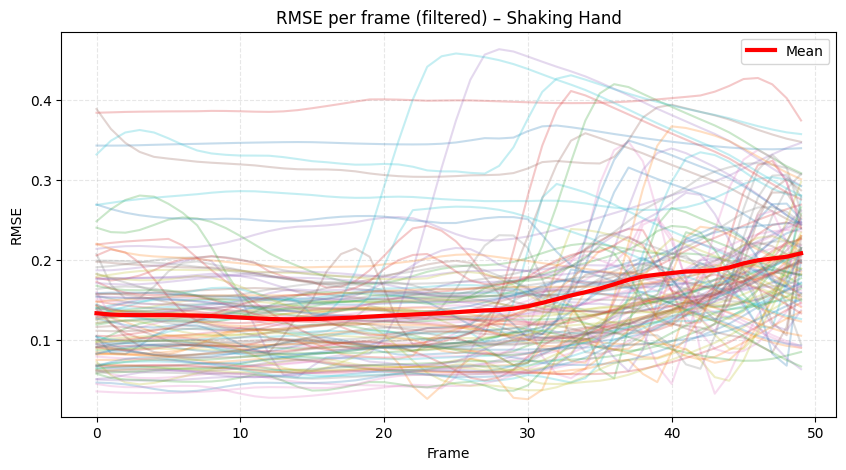

(array([0.09487686, 0.14107706, 0.15370027, 0.18181264, 0.25421653,
       0.15262815, 0.14979293, 0.14351322, 0.13098391, 0.15926764,
       0.11806513, 0.1347733 , 0.10251895, 0.20167967, 0.2015081 ,
       0.21035555, 0.11187479, 0.16854767, 0.16170016, 0.17182258,
       0.34806018, 0.09985651, 0.20792159, 0.23602894, 0.14129943,
       0.11736719, 0.15717107, 0.19407089, 0.10084656, 0.15659879,
       0.16106113, 0.1025915 , 0.1408006 , 0.1521392 , 0.17924373,
       0.33436401, 0.10499152, 0.17600401, 0.07707756, 0.15758691,
       0.10298208, 0.09478415, 0.24866217, 0.39633961, 0.29111146,
       0.15981934, 0.11760284, 0.22155707, 0.10436824, 0.1148983 ,
       0.103102  , 0.18007995, 0.19620022, 0.14681884, 0.18132961,
       0.13079316, 0.12572303, 0.16219984, 0.14318804, 0.10253711,
       0.16989033, 0.09193039, 0.11376614, 0.1419443 , 0.14551965,
       0.16914397, 0.15229183, 0.16903576, 0.15621599, 0.31633973,
       0.16542758, 0.19661713, 0.08867952, 0.07427708, 0.1063

In [41]:
def analyse_full_jester(): 
    for i in labels_jester:
        print(analyse_label_filtered(i, n = 200, target_len=50, n_basis=30)) 
    
analyse_full_jester()